In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import xarray as xr
import numpy as np
from natsort import natsorted
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [3]:
import sys
original_path = os.getcwd()  
os.chdir(original_path)
function_path = './functions/'
sys.path.append(function_path)
from smoothing_function import *
from model_analysis_function import *
from analysis_function import *
from Plot_function import *
from ar6_area_weighted_cont_global import *
# from obs_function import *

## Constrain global temperature
### Load global data

In [4]:
path = '/Users/tongli1997/Library/CloudStorage/OneDrive-UniversityofVictoria/Codes_run_on_local/Global_regional_attribution/Augest_Sep_2025/saved_data/'

file_name = '0.CRUT5&HadCRUT5.Tas.anomalies.AR6.continental.LSAT.GSAT.1850-2024.nc'
obs_all= xr.open_dataarray(path + file_name) 

file_name = '0.HadCRUT5.200runs.nan-masked.to.CRUT5.Tas.anomalies.AR6.continental.LSAT.GSAT.46regions_175years.nc'
obs_200runs_all = xr.open_dataarray(path + file_name) 

file_name = '0.Smoothed.His-ALL-nat-ant-ghg-oa.nan-masked.Tas.anomalies.AR6.continental.LSAT.GSAT.1850-2025.nc'
mod_all = xr.open_dataarray(path + file_name) 

file_name = '0.Large_ensembles.320runs.nan-masked.full.time.series.Tas.anomalies.AR6.continental.LSAT.GSAT.1850-2025.nc'
ln_mod_all = xr.open_dataarray(path + file_name) 

file_name = '0.pseudo-model_45.run1-3.Tas.anomalies.AR6.continental.LSAT.GSAT.46regions_176years.1850-2025.nc'
mod_45_pseudo = xr.open_dataarray(path + file_name) 

file_name = '0.Smoothed.His-Fu.24mod.1850-2100.non.masked.Tas.anomalies.AR6.continental.global.nc'
mod_all_his_fu= xr.open_dataarray(path + file_name).expand_dims(forcing = ['ALL'])

In [5]:
ref_period = (1850, 1900)
current_year = 2025
target_reg = ['GSAT']
constrain_used_reg = ['GSAT']


from f1_0_H_sum_multi_region_constrain import *

constrain_func = constrain_sum_reg
obs = obs_all
obs_200runs = obs_200runs_all
ln_mod = ln_mod_all
mod_his = mod_all_his_fu
mod_da = mod_all_his_fu
region_names = list(mod_da.names.values)
his_forcing = ['ALL']
sel_forcing=['ALL']

prior_mean, prior_cov, post_mean, post_cov = process_sum_multiple_region_mean_cov_constrain(constrain_func, constrain_used_reg, target_reg, his_forcing, sel_forcing, obs, obs_200runs, ln_mod, mod_his, mod_da)


prior_gsat_ref18 = change_ref(prior_mean.sel(forcing = 'ALL'), ref_period[0], ref_period[1])
post_gsat_ref18 = change_ref(post_mean.sel(forcing = 'ALL'), ref_period[0], ref_period[1])


def find_yr(data, threshold): 
    yr = int(data.where(data >= threshold, drop=True).year.values[0])
    print(yr)
    return (yr)

gsat_2_post = find_yr(post_gsat_ref18, threshold = 2)
gsat_15_post = find_yr(post_gsat_ref18, threshold = 1.5)

gsat_2_prior = find_yr(prior_gsat_ref18, threshold = 2)
gsat_15_prior = find_yr(prior_gsat_ref18, threshold = 1.5)


2042
2029
2041
2028


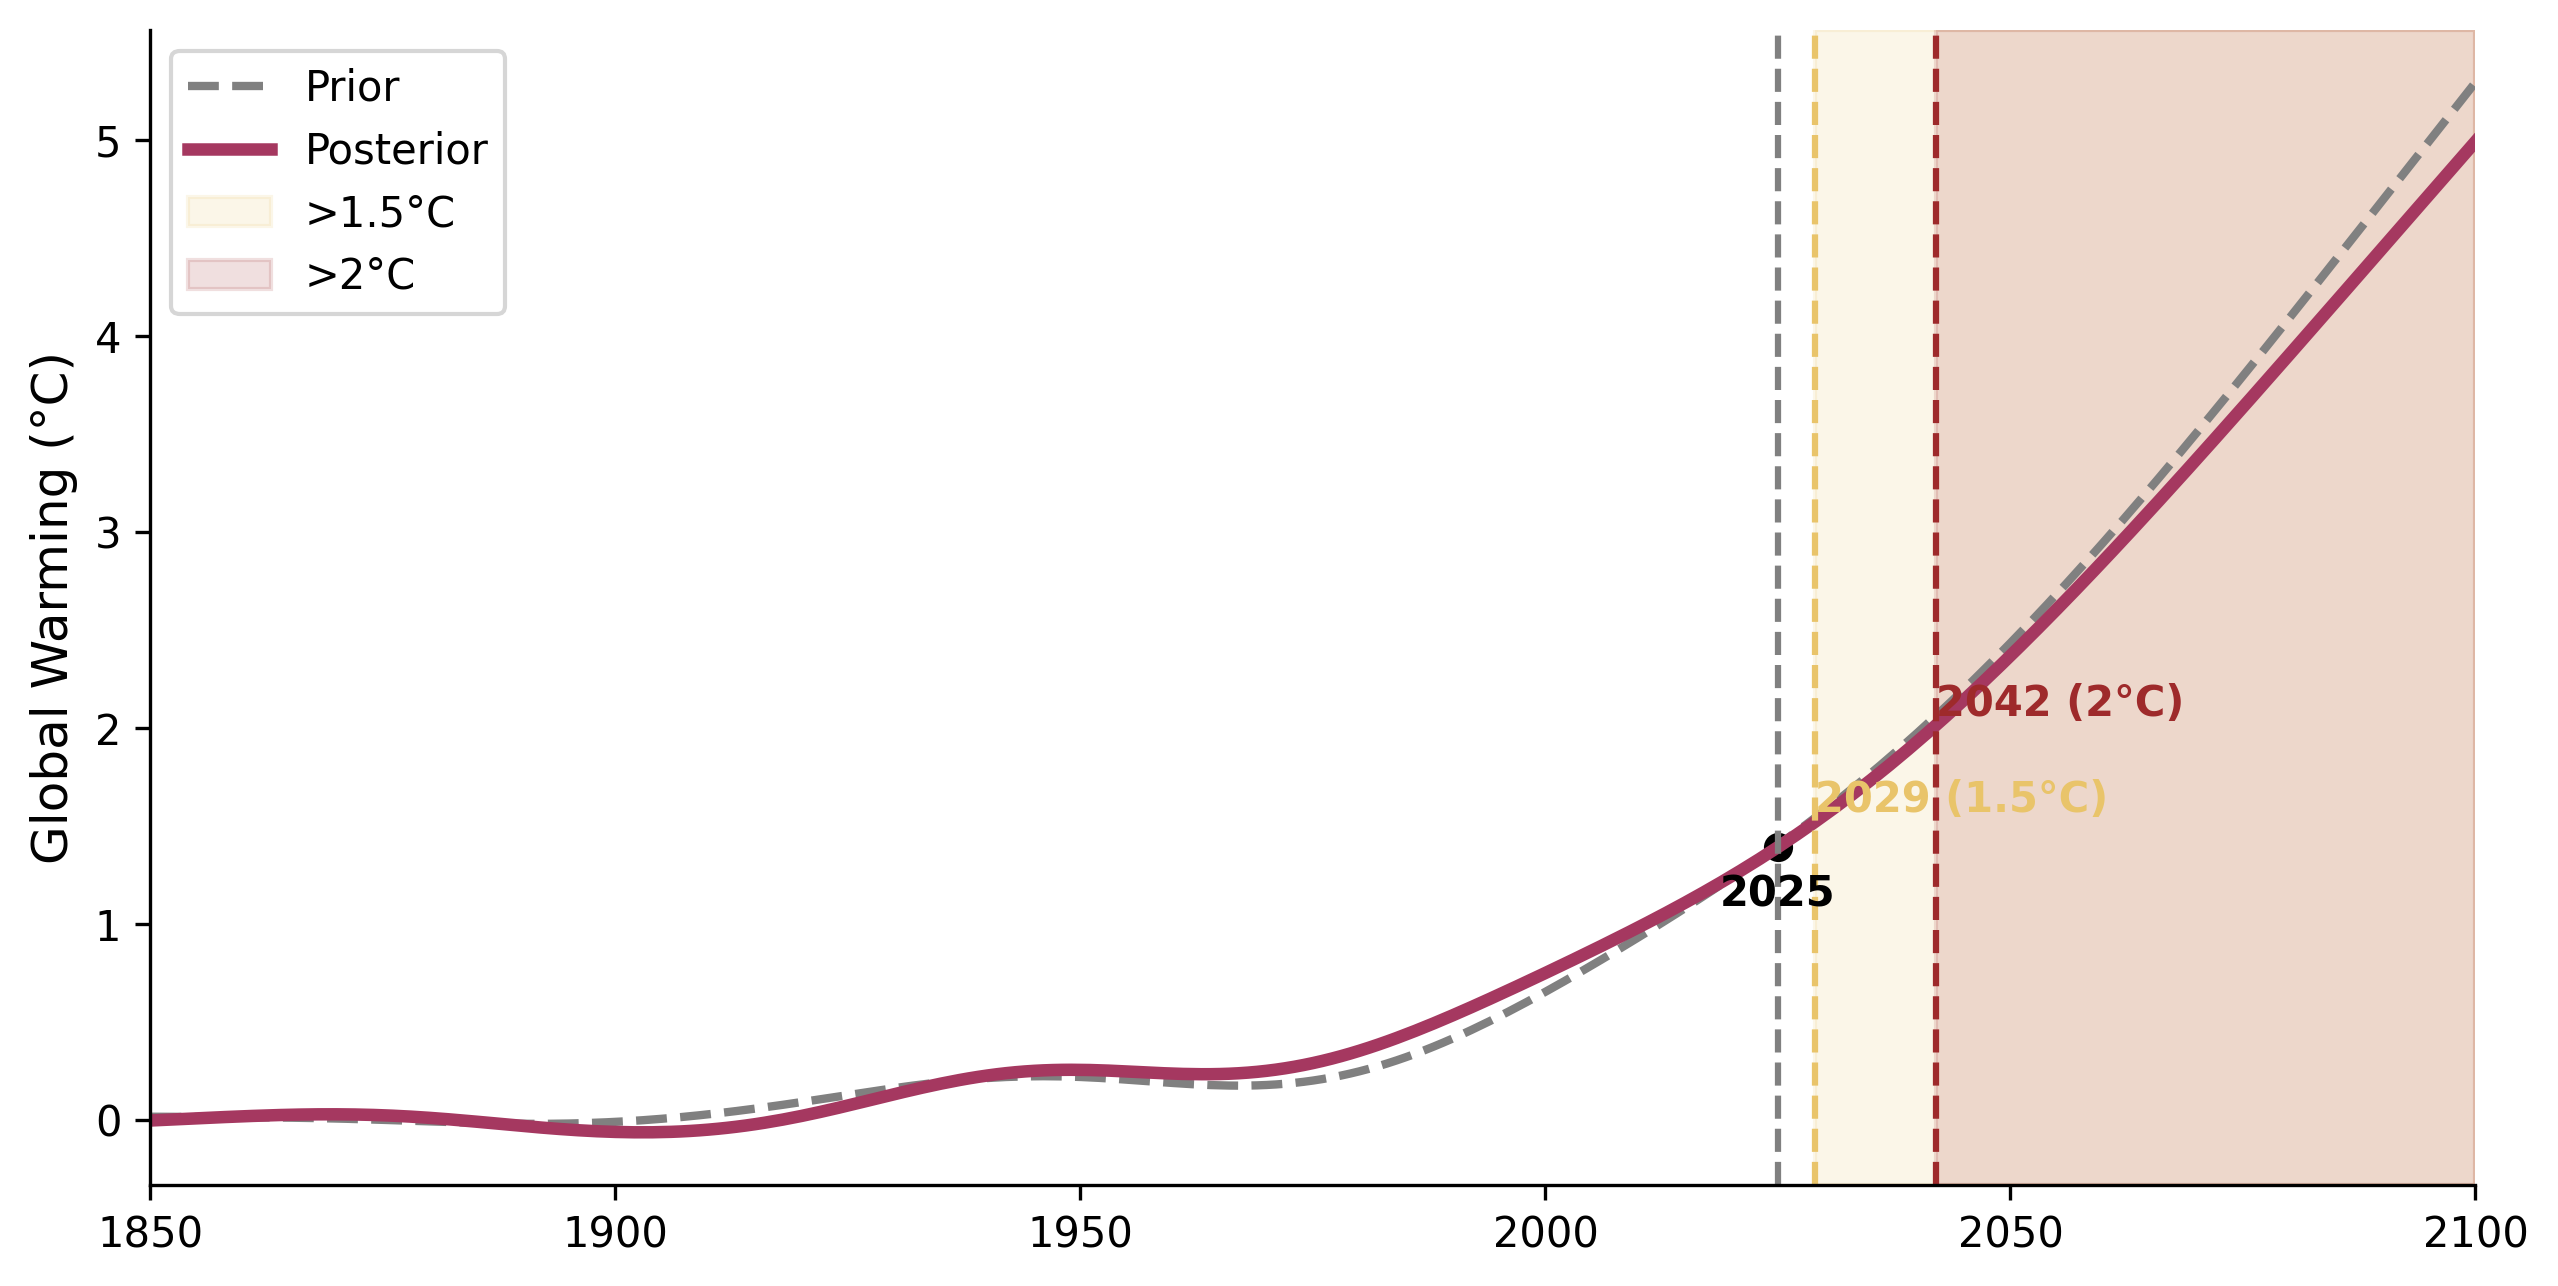

In [6]:

fig, ax = plt.subplots(1, 1, figsize=(10, 5
), dpi=300, sharey=True)

plt.plot(prior_gsat_ref18['year'], prior_gsat_ref18, label = 'Prior', color = 'gray', ls = '--', lw = 2)
plt.plot(post_gsat_ref18['year'], post_gsat_ref18, label = 'Posterior', color = '#a53860', ls = '-', lw = 3)


color_15 = '#e9c46a'
color_2 = '#9e2a2b'
# Shade time period after 1.5°C
ax.axvspan(gsat_15_post, 2100, color= color_15, alpha=0.15, label='>1.5°C')

# Shade time period after 2°C
ax.axvspan(gsat_2_post, 2100, color= color_2, alpha=0.15, label='>2°C')


ax.axvline(gsat_15_post, color= color_15, ls='--', lw=1.5)
ax.axvline(gsat_2_post, color= color_2, ls='--', lw=1.5)

ax.axvline(current_year, color='gray', ls='--', lw=1.5)

# ---- Label 1.5°C ----
y15 = post_gsat_ref18.sel(year=gsat_15_post)
ax.text(gsat_15_post, y15 + 0.05,
        f"{gsat_15_post} (1.5°C)",
        color= color_15, ha='left', weight = 'bold', fontsize=10)

# ---- Label 2°C ----
y2 = post_gsat_ref18.sel(year=gsat_2_post)
ax.text(gsat_2_post, y2 + 0.05,
        f"{gsat_2_post} (2°C)",
        color= color_2, ha='left', weight = 'bold', fontsize=10)

# ---- Label current year ----
y_curr = post_gsat_ref18.sel(year=current_year)
ax.scatter(current_year, y_curr, color='black')
ax.text(current_year, y_curr - 0.3,
        f"{current_year}",
        color='black', ha='center', weight = 'bold', fontsize=10)

ax.set_ylabel("Global Warming (°C)", fontsize=12)

plt.xlim(1850, 2100)
plt.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### Load the regional, global land constraint results

### Constrained warming relative to current year 2025

In [7]:
path = './saved_data/'

def load_xr_pickle(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)
        
post_smooth_ALL_ref2025 = load_xr_pickle(path + '2.2_constrained_46reg_lsat_smoothed_warming_ref2025_1850-2100.pkl')

post_smooth_ALL_ref1850 = load_xr_pickle(path + '2.3_constrained_46reg_lsat_smoothed_warming_ref1850_1850-2100.pkl')


In [8]:
post_warming_15_ref2025 = post_smooth_ALL_ref2025.sel(year = slice(gsat_15_post-5, gsat_15_post+5)).mean('year').squeeze()
post_warming_2_ref2025 = post_smooth_ALL_ref2025.sel(year = slice(gsat_2_post-5, gsat_2_post+5)).mean('year').squeeze()

post_warming_15_ref2025

<xarray.DataArray 'post_mean_5_95_smooth' (region: 47, quantile: 3)> Size: 1kB
array([[ 0.20458231, -0.67524248,  1.0468591 ],
       [ 0.27833018, -0.35440573,  0.94008105],
       [ 0.28645529, -0.42134735,  0.98873438],
       [ 0.17543673, -0.18241563,  0.53480747],
       [ 0.18790954, -0.15532816,  0.63556523],
       [ 0.18313783, -0.11469552,  0.47507634],
       [ 0.15954515, -0.07016063,  0.4367431 ],
       [ 0.12858298, -0.06484262,  0.3183661 ],
       [ 0.1132179 , -0.06592689,  0.24472881],
       [ 0.13991918, -0.11321483,  0.49853597],
       [ 0.16497162, -0.29460593,  0.61764681],
       [ 0.14082543, -0.14971647,  0.40054396],
       [ 0.19369161, -0.1804877 ,  0.66172314],
       [ 0.12483196, -0.05637203,  0.45236295],
       [ 0.11985504, -0.10254222,  0.3917011 ],
       [ 0.0771059 , -0.1346365 ,  0.29787875],
       [ 0.16534196, -0.35219436,  0.68590002],
       [ 0.21709359, -0.22743072,  0.49971707],
       [ 0.24811227, -0.25798895,  0.71058992],
       [ 0.17391327, -0.11467293,  0.40111157],
...
       [ 0.12473985, -0.09666706,  0.28114286],
       [ 0.33512045, -0.61217573,  1.35252434],
       [ 0.25530366, -0.34390955,  0.76743756],
       [ 0.27370895, -0.24856796,  0.66155163],
       [ 0.21170335, -0.32819332,  0.73810689],
       [ 0.2093444 , -0.12507211,  0.62964759],
       [ 0.2153376 , -0.14178748,  0.58920989],
       [ 0.20579476, -0.20332479,  0.65585307],
       [ 0.19331956, -0.1609187 ,  0.4310655 ],
       [ 0.19803603, -0.14930423,  0.46272092],
       [ 0.15714584, -0.09853868,  0.5160585 ],
       [ 0.11447526, -0.06799823,  0.318197  ],
       [ 0.1159284 , -0.10304662,  0.27390783],
       [ 0.15950345, -0.17313876,  0.44181133],
       [ 0.15074554, -0.10956677,  0.39734992],
       [ 0.07885156, -0.11276287,  0.29948629],
       [ 0.10877877, -0.12131304,  0.31527659],
       [ 0.14490831, -0.42718661,  0.74804244],
       [ 0.1396082 , -0.68695664,  0.95645863],
       [ 0.16975066, -0.13414683,  0.48019601]])
Coordinates:
  * region       (region) int64 376B 0 1 2 3 4 5 6 7 ... 39 40 41 42 43 44 45 46
    forcing      <U3 12B 'ALL'
  * quantile     (quantile) <U4 48B 'mean' '5th' '95th'
    abbrevs      (region) <U4 752B 'GIC' 'NWN' 'NEN' ... 'EAN' 'WAN' 'LSAT'
    names        (region) <U25 5kB 'Greenland/Iceland' ... 'Global Land'
    realization  int64 8B 100

In [9]:
current_yr = 2025
post_warming_current_year = post_smooth_ALL_ref1850.sel(year = current_yr, quantile = 'mean').squeeze()

percent_nowaday_15 = (post_warming_current_year / (post_warming_current_year + post_warming_15_ref2025)) * 100
percent_nowaday_2 = (post_warming_current_year / (post_warming_current_year + post_warming_2_ref2025)) * 100


## switch 5, 95th, cause it is on denorminator
percent_nowaday_15 = percent_nowaday_15.rename({'quantile': 'quantile'})
percent_nowaday_15 = percent_nowaday_15.assign_coords(
    quantile=['95th' if q == '5th' else '5th' if q == '95th' else q for q in percent_nowaday_15['quantile'].values]
)

percent_nowaday_2 = percent_nowaday_2.rename({'quantile': 'quantile'})
percent_nowaday_2 = percent_nowaday_2.assign_coords(
    quantile=['95th' if q == '5th' else '5th' if q == '95th' else q for q in percent_nowaday_2['quantile'].values]
)
percent_nowaday_15

<xarray.DataArray 'post_mean_5_95_smooth' (region: 47, quantile: 3)> Size: 1kB
array([[ 92.65996559, 135.40143852,  71.1568436 ],
       [ 91.50079361, 113.41408114,  76.11903849],
       [ 91.93735047, 114.80976028,  76.76380218],
       [ 91.4866098 , 110.71229103,  77.90130341],
       [ 91.66847688, 108.1231491 ,  76.48719599],
       [ 91.12240593, 106.49800369,  79.82571115],
       [ 91.41201115, 104.309449  ,  79.54334945],
       [ 91.17490718, 105.13161854,  80.6675772 ],
       [ 91.45297885, 105.75528072,  83.19353001],
       [ 91.1867078 , 108.48395223,  74.38425878],
       [ 90.76032751, 122.21943603,  72.40363641],
       [ 92.54666507, 109.3637961 ,  81.36265374],
       [ 90.64571138, 110.63920974,  73.9340524 ],
       [ 89.62804122, 105.51397388,  70.454716  ],
       [ 92.16499222, 107.84357614,  78.25795388],
       [ 92.75057642, 115.80478325,  76.80771245],
       [ 92.68527522, 120.2078096 ,  75.33582826],
       [ 91.61427837, 110.60617469,  82.59717788],
       [ 91.37051889, 110.88988761,  78.7098593 ],
       [ 91.35819055, 106.65203539,  82.09053034],
...
       [ 91.21585703, 108.06465956,  82.16619322],
       [ 92.2638738 , 118.08712739,  74.71583229],
       [ 91.11453831, 115.12314701,  77.33101632],
       [ 91.20870376, 109.5930279 ,  81.10527819],
       [ 91.3845264 , 117.11703612,  75.26160645],
       [ 91.67059401, 105.74014712,  78.53684211],
       [ 90.82608271, 107.1244418 ,  78.34705089],
       [ 91.86553226, 109.58721501,  77.99127774],
       [ 90.50846324, 109.56415375,  81.04792657],
       [ 91.5401462 , 107.48935881,  82.2411329 ],
       [ 90.54258198, 107.00878936,  74.45921624],
       [ 91.72086398, 105.66546976,  79.94241653],
       [ 91.66939726, 108.78771183,  82.32369386],
       [ 91.44900469, 111.29648605,  79.42794124],
       [ 91.35444001, 107.38666152,  80.03489859],
       [ 93.91755101, 110.20696448,  80.25816157],
       [ 91.58038712, 111.42439645,  78.96005297],
       [ 91.5977523 , 137.06471589,  67.86443936],
       [ 92.3015731 , 169.60757926,  63.63709953],
       [ 91.6321289 , 107.777968  ,  79.47043038]])
Coordinates:
  * region       (region) int64 376B 0 1 2 3 4 5 6 7 ... 39 40 41 42 43 44 45 46
    year         int64 8B 2025
    forcing      <U3 12B 'ALL'
    abbrevs      (region) <U4 752B 'GIC' 'NWN' 'NEN' ... 'EAN' 'WAN' 'LSAT'
    names        (region) <U25 5kB 'Greenland/Iceland' ... 'Global Land'
    realization  int64 8B 100
  * quantile     (quantile) <U4 48B 'mean' '95th' '5th'

### Global land constrain


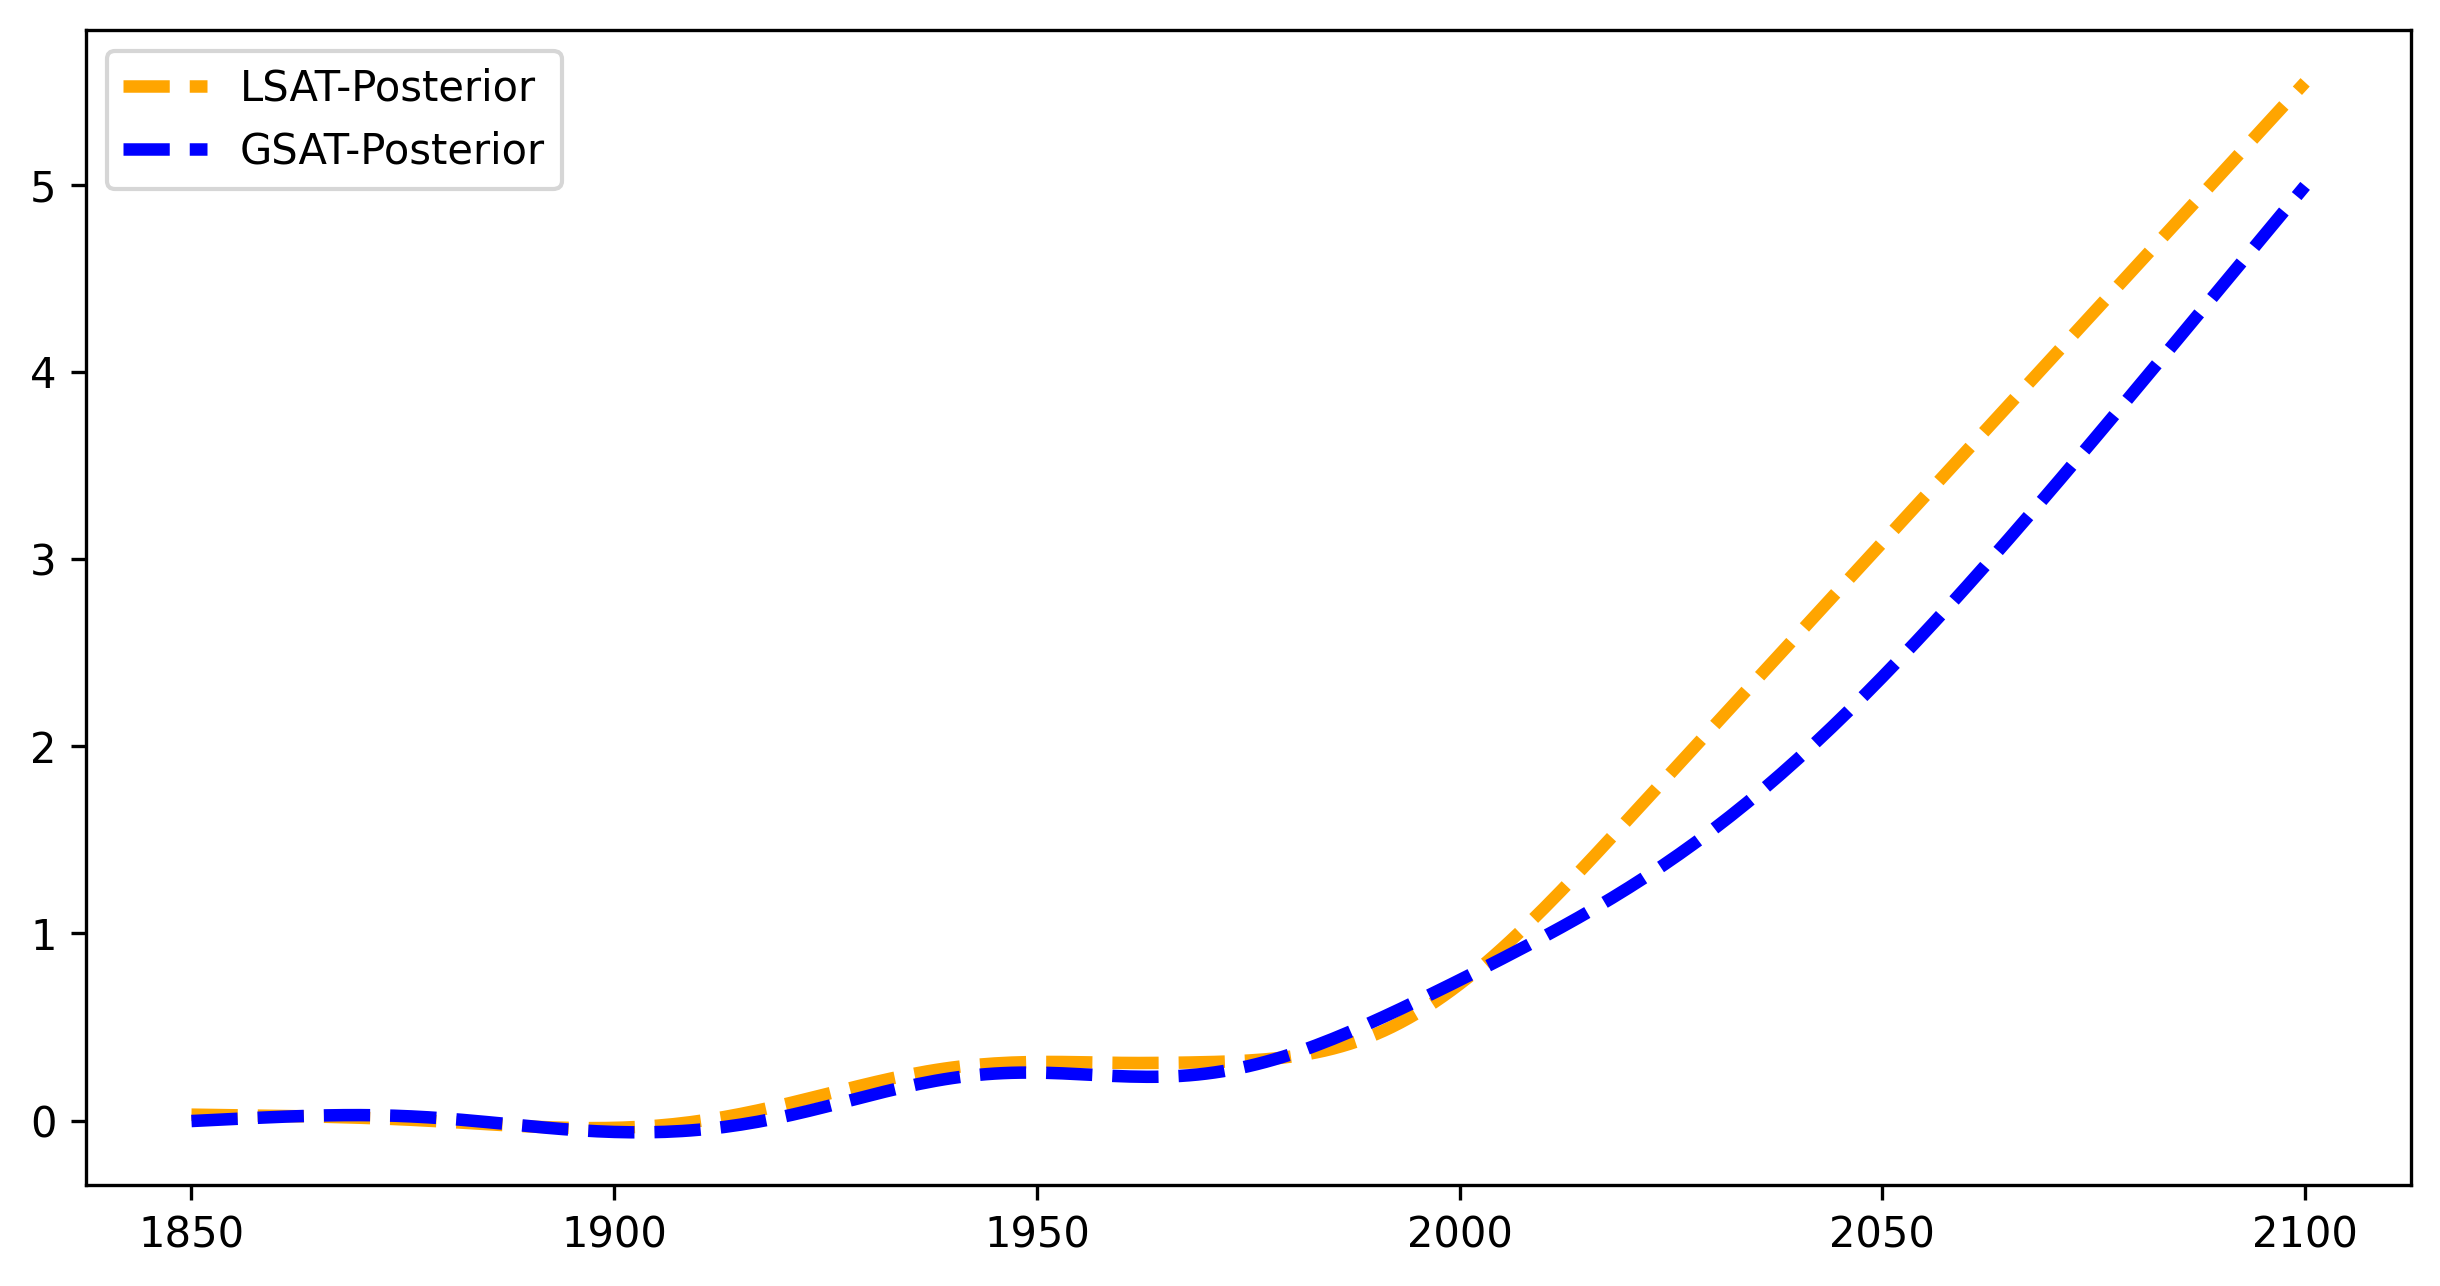

In [10]:
# lsat_prior = prior_smooth_ALL_ref1850.sel(region = 46, quantile = 'mean').squeeze()
lsat_post = post_smooth_ALL_ref1850.sel(region = 46, quantile = 'mean').squeeze()


fig, ax = plt.subplots(1, 1, figsize=(10, 5
), dpi=300, sharey=True)

# plt.plot(lsat_prior['year'], lsat_prior, label = 'LSAT-Prior', color = 'orange', ls = '-', lw = 2)
plt.plot(lsat_post['year'], lsat_post, label = 'LSAT-Posterior', color = 'orange', ls = '--', lw = 3)

# plt.plot(prior_gsat_ref18['year'], prior_gsat_ref18, label = 'GSAT-Prior', color = 'blue', ls = '-', lw = 2)
plt.plot(post_gsat_ref18['year'], post_gsat_ref18, label = 'GSAT-Posterior', color = 'blue', ls = '--', lw = 3)

plt.legend()
plt.show()

### Map plotting

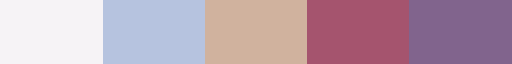

In [11]:
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap


cmap_percent = modify_cmap('twilight', start=0.0, end=0.9, gamma=1.0, white_strength=0.7)   # example: different color map
bounds2 = np.arange(50, 110, 10)  # example levels
norm2 = mcolors.BoundaryNorm(boundaries=bounds2, ncolors=256, extend='neither')

n_colors = len(bounds2) - 1  # = 5

# Get discrete colors from the colormap
colors_n = [cmap_percent(i / (n_colors - 1)) for i in range(n_colors)]

# Swap the 5th color into 3rd position
# Note: Python is 0-based -> 5th = index 4, 3rd = index 2
colors_n[2], colors_n[4] = colors_n[4], colors_n[2]

# Create a new colormap with the modified order
cmap_percent = mcolors.ListedColormap(colors_n)

# Recreate the norm
norm2 = mcolors.BoundaryNorm(boundaries=bounds2, ncolors=cmap_percent.N, extend='neither')

cmap_percent

/var/folders/jt/kr53pz_j4x3d_32xbfb7pkd87_b0mf/T/ipykernel_85468/3531396450.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


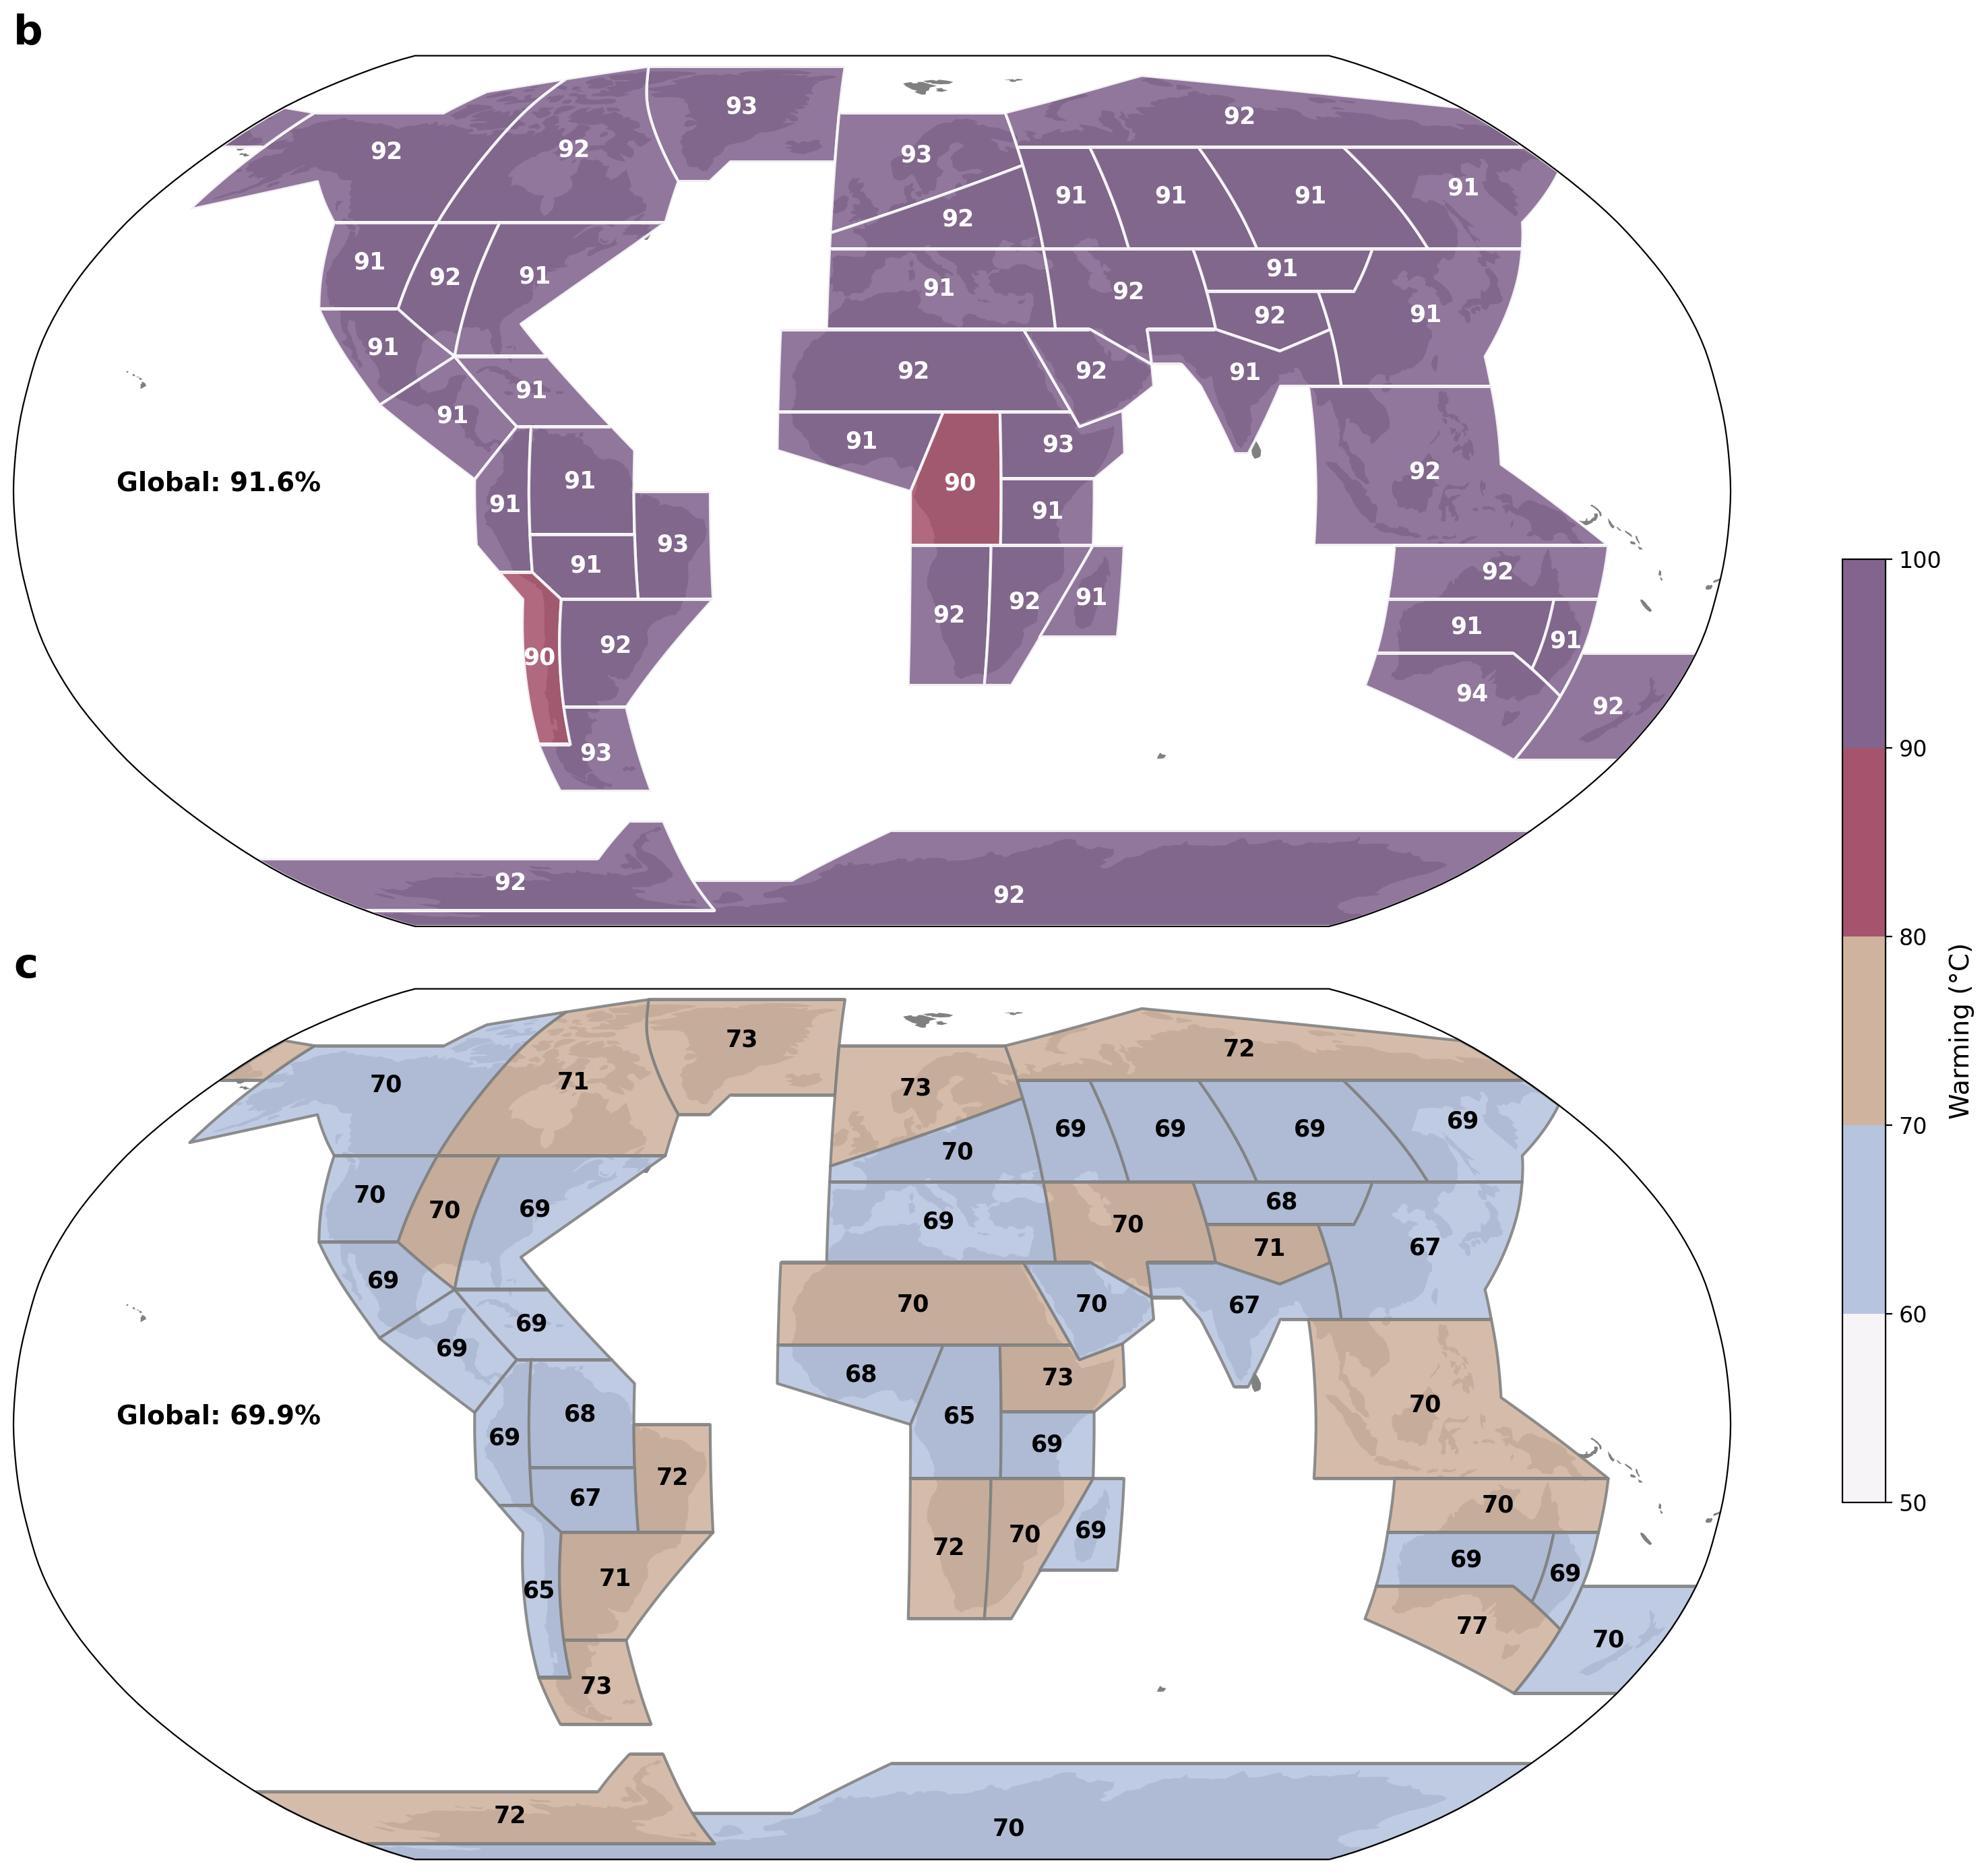

In [12]:
def plot_panel(ax, data, title, cmap, norm, decimals,
               global_value=None, unit="°C"):
    
    ax.set_global()
    norm0 = plot_ar6_region_data_on_ax_new(
        ax, data, cmap=cmap, norm=norm, decimals=decimals
    )

    # ---- Add title ----
    ax.set_title(title, fontsize=22, fontweight='bold', loc='left')

    # ---- Add the global value with a unit ----
    if global_value is not None:
        ax.text(
            0.06, 0.5,
            f"Global: {global_value:.1f}{unit}",   # unit inserted here
            transform=ax.transAxes,
            fontsize=14,
            fontweight='bold',
            color='black',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=4)
        )

    return norm0

# ---- Data dictionary ----
# data_dict = {
#     "(b) Nowadays to 1.5°C": percent_nowaday_15.sel(quantile = 'mean'),     # existing data
#     "(c) Nowadays to 2°C": percent_nowaday_2.sel(quantile = 'mean')    # add your second data array here
# }

data_dict = {
    "b": percent_nowaday_15.isel(region = slice(0,46)).sel(quantile = 'mean'),     # existing data
    "c": percent_nowaday_2.isel(region = slice(0,46)).sel(quantile = 'mean')    # add your second data array here
}

global_15 = percent_nowaday_15.where(percent_nowaday_15.abbrevs == 'LSAT', drop=True).sel(quantile = 'mean').values.item()
global_2 = percent_nowaday_2.where(percent_nowaday_2.abbrevs == 'LSAT', drop=True).sel(quantile = 'mean').values.item()

global_values = {
    "b": global_15,
    "c": global_2
}

# ---- Plot 2 panels ----
fig, axes = plt.subplots(2, 1, figsize=(16, 14), subplot_kw={'projection': ccrs.Robinson()}, dpi=200)

for ax, (label, data) in zip(axes, data_dict.items()):
    plot_panel(ax, data, f"{label}", cmap_percent, norm2, decimals = 0, global_value=global_values[label], unit = '%')

# ---- Shared colorbar ----
sm = mpl.cm.ScalarMappable(cmap=cmap_percent, norm=norm2)
sm.set_array([])

# [left, bottom, width, height] in figure coordinates (0–1)
cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.5])  
cb = fig.colorbar(sm, cax=cbar_ax)
cb.ax.tick_params(labelsize=12)
cb.set_label("Warming (°C)", fontsize=14)

plt.tight_layout()
plt.show()


/var/folders/jt/kr53pz_j4x3d_32xbfb7pkd87_b0mf/T/ipykernel_85468/669259954.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


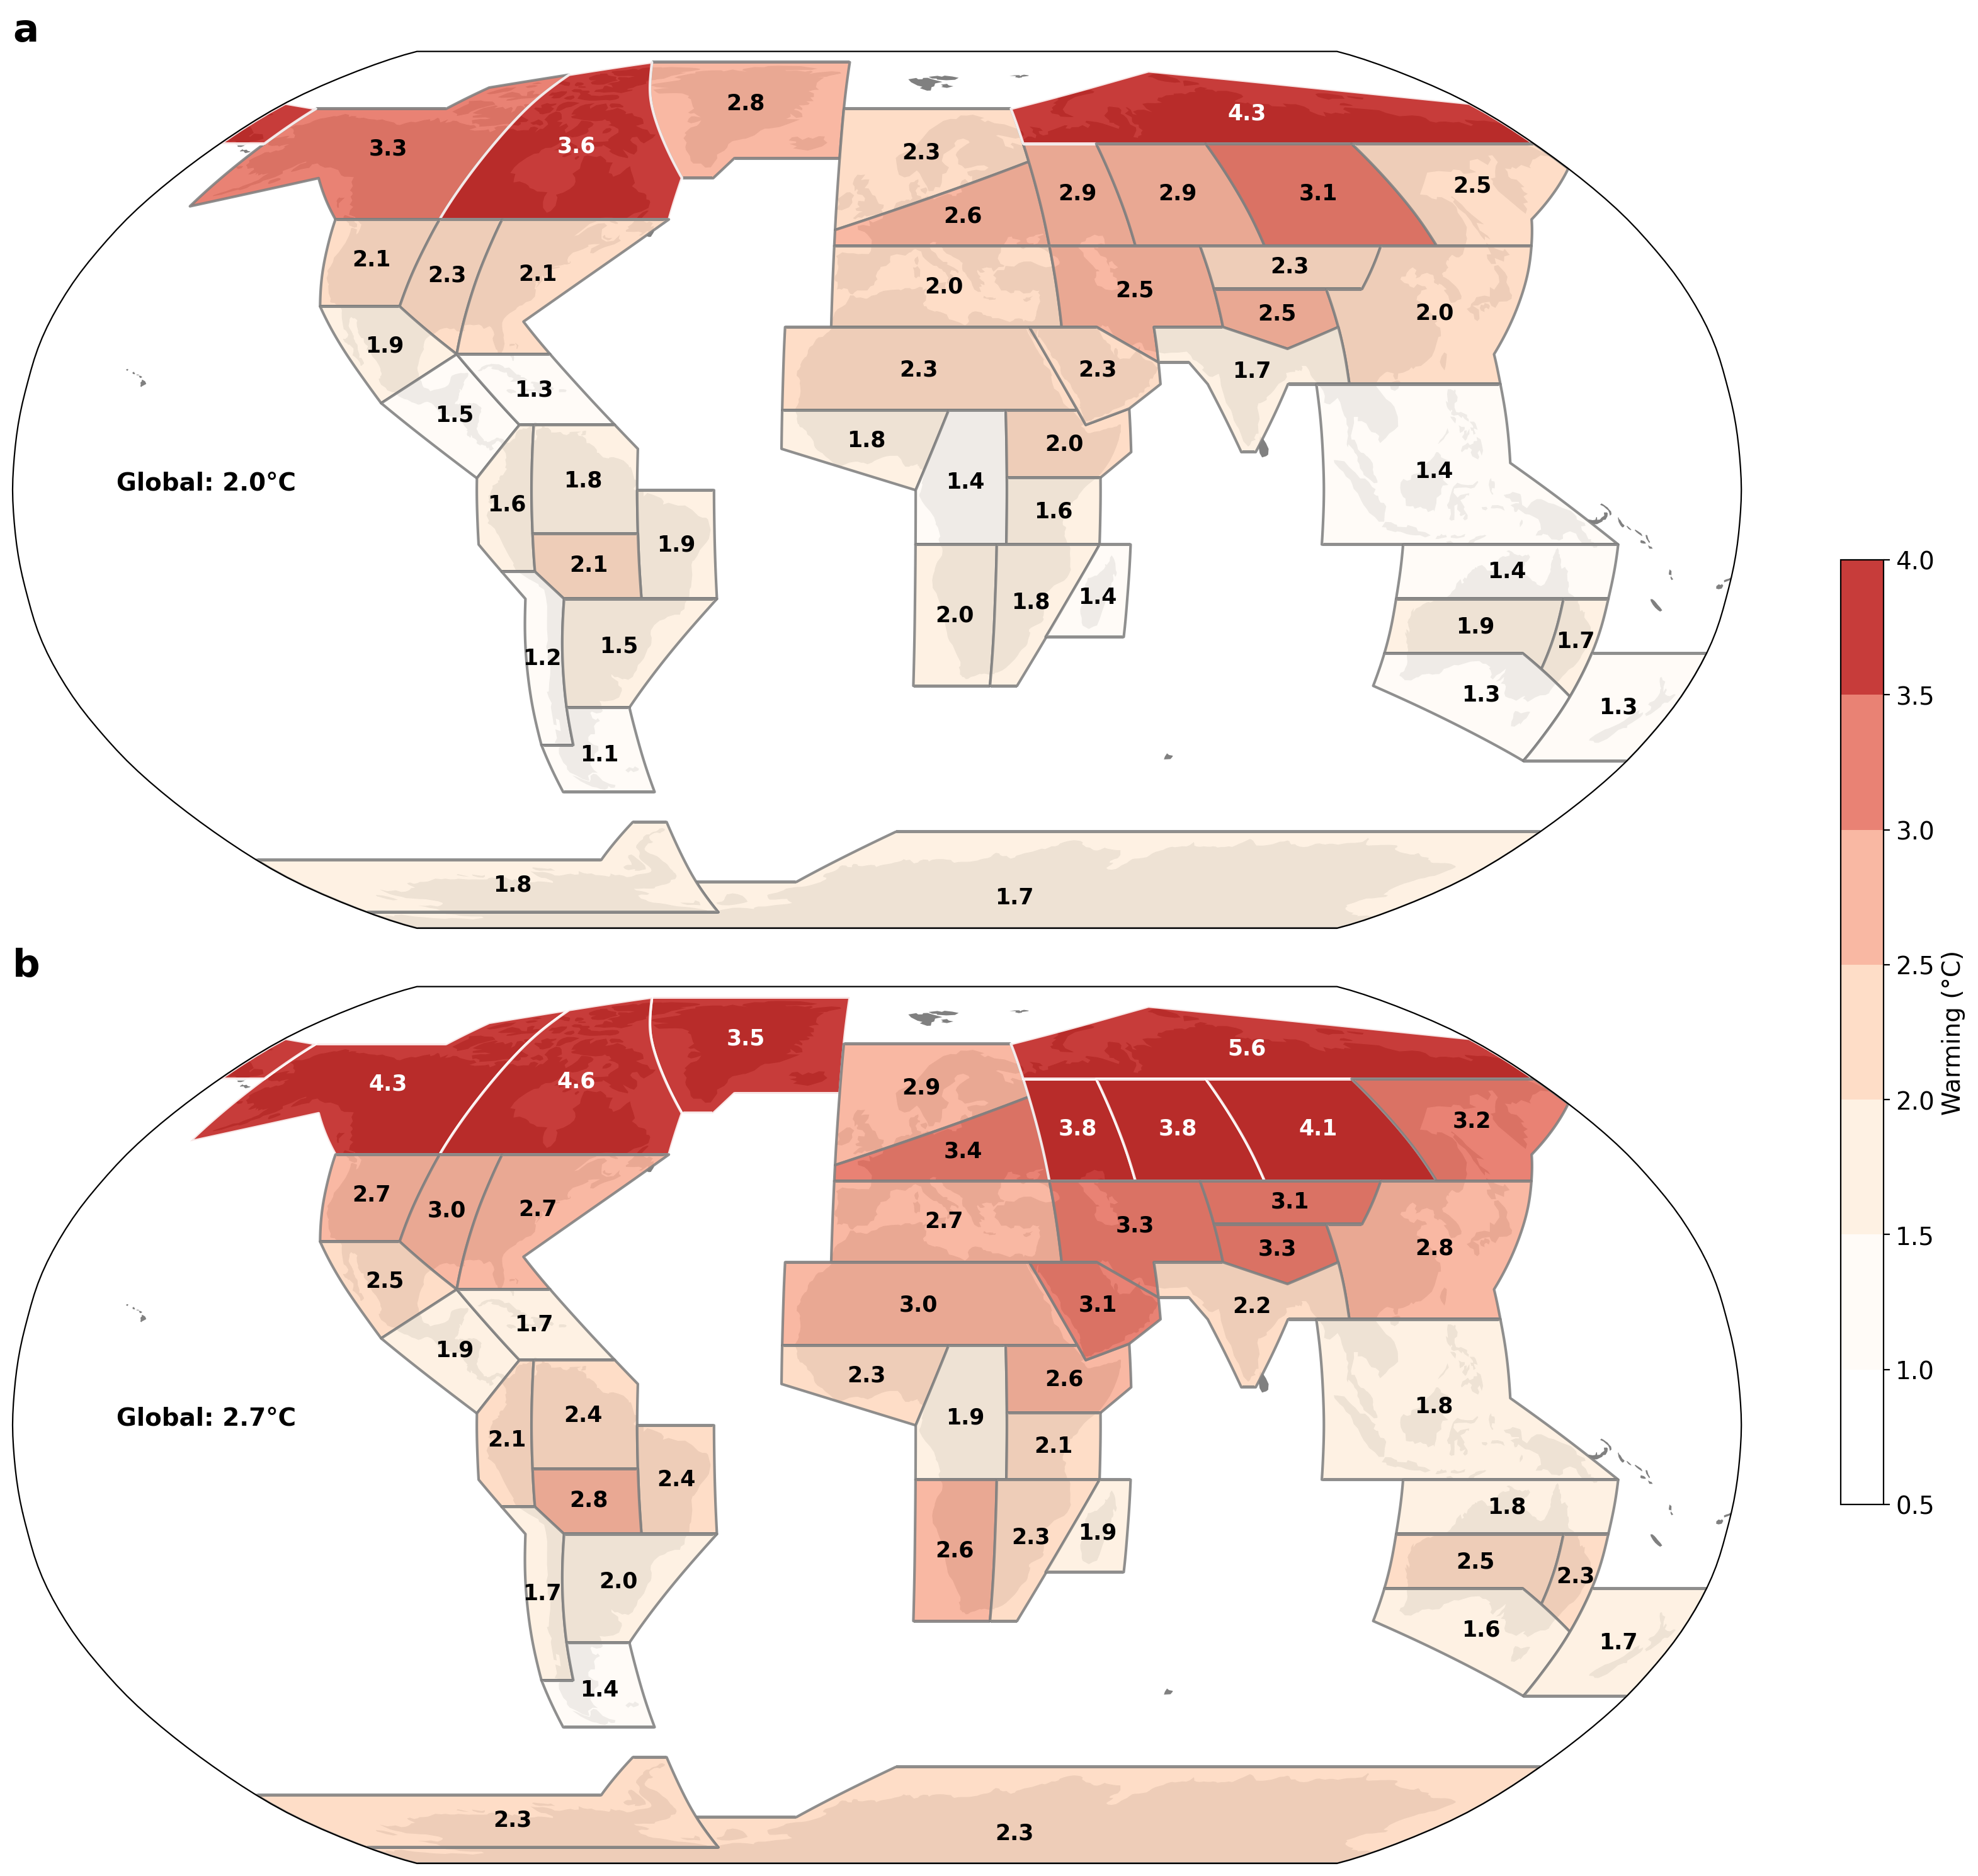

In [13]:
def set_cmap_alpha(cmap, alpha=1.0):
    colors = cmap(np.arange(cmap.N))
    colors[:, -1] = alpha
    return mpl.colors.ListedColormap(colors)

cmap = modify_cmap('OrRd', start=0.0, end=0.95, gamma=1.0, white_strength=1.0)
colors_array = cmap(np.linspace(0, 1, 256))
truncated_colors = colors_array[:230]
truncated_cmap = mcolors.LinearSegmentedColormap.from_list('truncated_YlOrBr', truncated_colors)
cmap_with_alpha = set_cmap_alpha(truncated_cmap, alpha=0.88)


# ---- Data dictionary ----
# data_dict = {
#     "1.5°C Warming world": post_warming_15_ref2025.sel(quantile = 'mean') + post_warming_current_year,
#     "2°C Warming world": post_warming_2_ref2025.sel(quantile = 'mean') + post_warming_current_year    # add your second data array here
# }

data_a = (post_warming_15_ref2025.sel(quantile = 'mean') + post_warming_current_year).isel(region = slice(0, 46))
data_b = (post_warming_2_ref2025.sel(quantile = 'mean') + post_warming_current_year).isel(region = slice(0, 46))

data_dict = {
    "a": data_a,
    "b": data_b    # add your second data array here
}

global_15 = (post_warming_15_ref2025.sel(quantile = 'mean') + post_warming_current_year).where(post_warming_15_ref2025.abbrevs == 'LSAT', drop=True).values.item()

global_2 = (post_warming_2_ref2025.sel(quantile = 'mean') + post_warming_current_year).where(post_warming_2_ref2025.abbrevs == 'LSAT', drop=True).values.item()

global_values = {
    "a": global_15,
    "b": global_2
}

bounds = np.arange(0.5, 4.5, 0.5)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='neither')

# ---- Plot 2 panels ----
fig, axes = plt.subplots(2, 1, figsize=(17, 15), subplot_kw={'projection': ccrs.Robinson()}, dpi=200)
for ax, (label, data) in zip(axes, data_dict.items()):
    plot_panel(ax, data, f"{label}", cmap_with_alpha, norm, decimals = 1, global_value=global_values[label], unit = '°C')

# ---- Shared colorbar ----
sm = mpl.cm.ScalarMappable(cmap=cmap_with_alpha, norm=norm)
sm.set_array([])


# [left, bottom, width, height] in figure coordinates (0–1)
cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.5])  
cb = fig.colorbar(sm, cax=cbar_ax)
cb.ax.tick_params(labelsize=14)
cb.set_label("Warming (°C)", fontsize=14)

plt.tight_layout()
plt.show()

### Uncertainty

In [14]:
labels = post_warming_15_ref2025.coords['abbrevs'].values

groups = {
    'North and Central America': ['GIC', 'NWN', 'NEN', 'WNA', 'CNA', 'ENA', 'NCA', 'SCA', 'CAR'],
    'South America': ['NWS', 'NSA', 'NES', 'SAM', 'SWS', 'SES', 'SSA'],
    'Europe': ['NEU', 'WCE', 'EEU', 'MED'],
    'Africa': ['SAH', 'WAF', 'CAF', 'NEAF', 'SEAF', 'WSAF', 'ESAF', 'MDG'],
    'Asia': ['RAR', 'WSB', 'ESB', 'RFE', 'WCA', 'ECA', 'TIB', 'EAS', 'ARP', 'SAS'],
    'Australasia': ['SEA', 'NAU', 'CAU', 'EAU', 'SAU', 'NZ'],
    'Antarctica': ['EAN', 'WAN'],
    'Global land': ['LSAT']
}

# Create a mapping from abbrev to index
abbrev_to_index = {abbr: i for i, abbr in enumerate(labels)}
continent_indices = {k: [abbrev_to_index[abbr] for abbr in v] for k, v in groups.items()}


colors = {
    'North and Central America': '#c45a5c',  # soft green
    'South America': '#a9b5da',               # lavender blue
    'Europe': '#f5a966',                      # warm yellow-orange
    'Africa': '#bab1a0',                      # muted red
    'Asia': '#b47955',                        # light blue
    'Australasia': '#6e9c6d',                 # forest green
    'Antarctica': '#5590B4',                   # brick red
    'Global land': '#dda15e'
}

uncertainty_ref_period=(1850, 2025)
ref_period=(1850, 1900)
obs_adjust_ref_period=(1961, 2023)
warming_target_period=(2016, 2025)

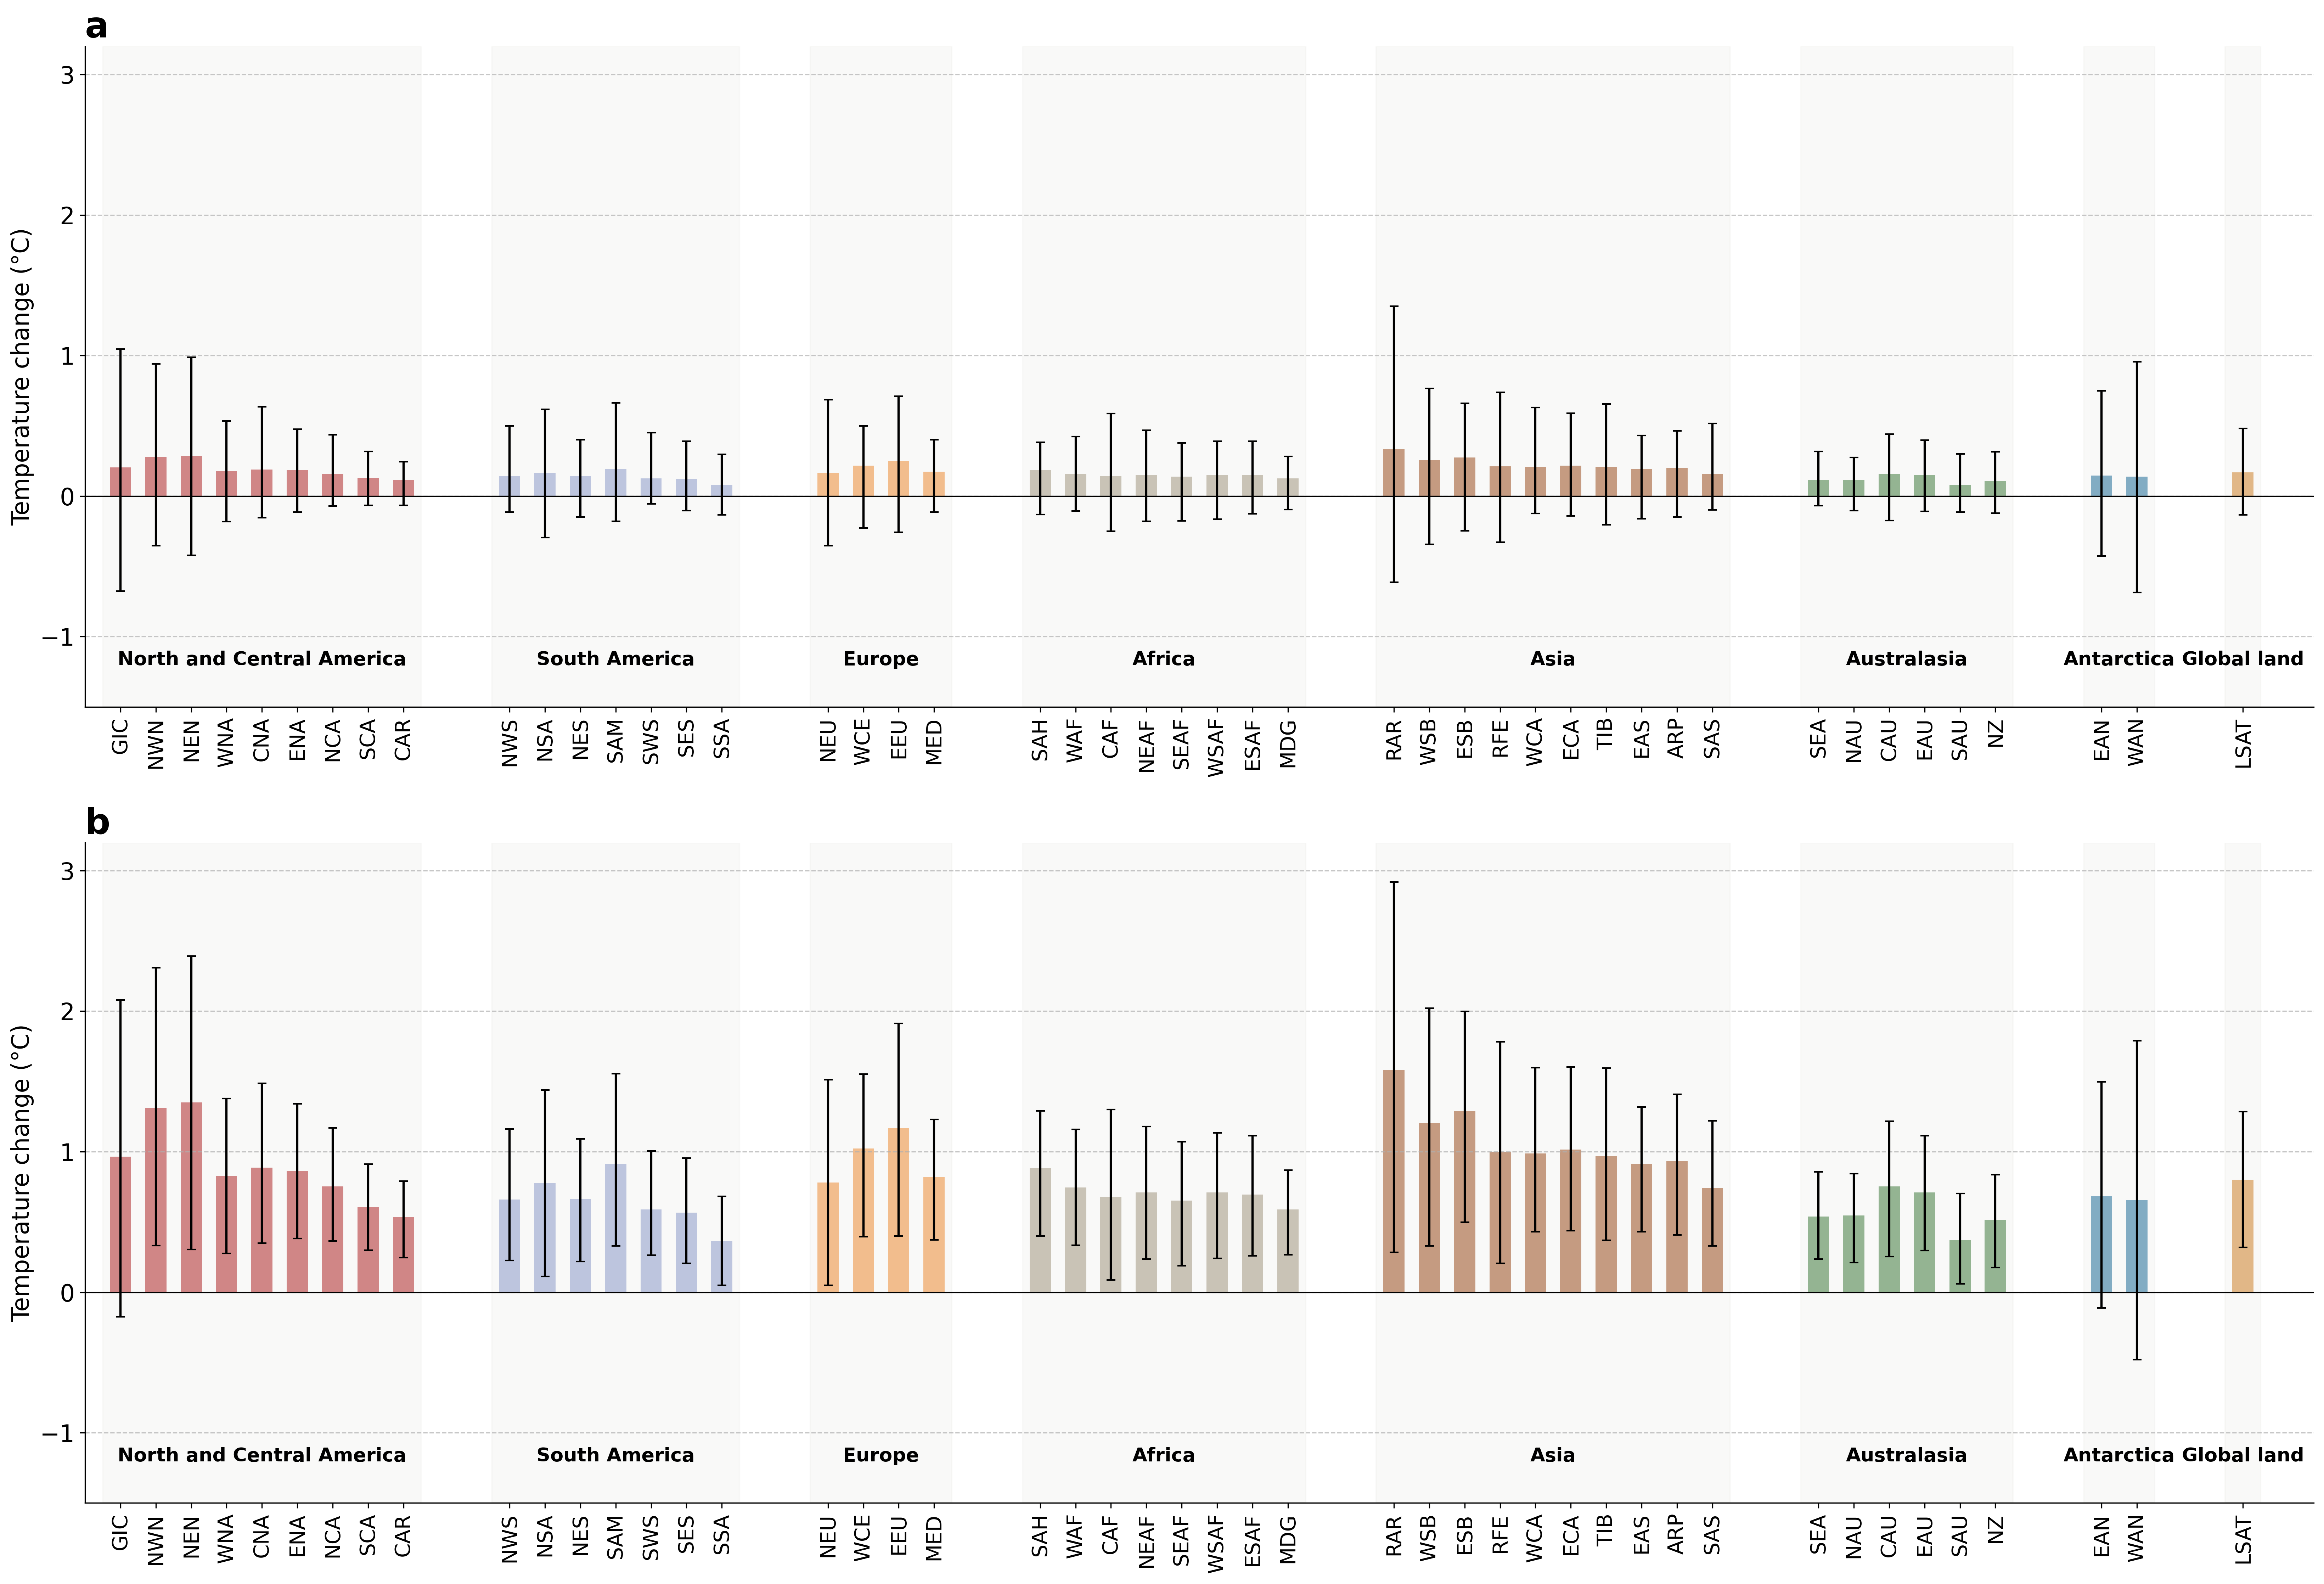

In [15]:
def plot_panel(ax, data, title, colors, continent_indices, labels, y_label, continent_height_value = -0.5, ylim_low = -1, ylim_high = 6, continent_label = 'True'):
    mean = data.sel(quantile='mean')
    err_lower = mean - data.sel(quantile='5th')
    err_upper = data.sel(quantile='95th') - mean

    bar_width = 0.6
    gap = 2

    x_ticks = []
    x_labels = []
    current_x = 0

    for continent, indices in continent_indices.items():
        for idx in indices:
            ax.bar(current_x, mean[idx], 
                   yerr=[[err_lower[idx]], [err_upper[idx]]],
                   color=colors[continent], capsize=3, alpha=1, width = bar_width)
            x_ticks.append(current_x)
            x_labels.append(labels[idx])
            current_x += 1
        current_x += gap

    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, rotation=90, fontsize=14)
    ax.set_ylabel(y_label, fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_title(title, loc='left', fontsize=24, fontweight='bold')
    ax.axhline(0, color='black', linewidth=0.8)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)


    # Background and continent labels
    current_x = 0
    for continent, indices in continent_indices.items():
        group_width = len(indices)
        ax.axvspan(current_x - 0.5, current_x + group_width - 0.5, color='#edede9', alpha=0.3)
        group_center = current_x + group_width / 2 - 0.5

        if continent_label == 'True':
            ax.text(group_center, continent_height_value,
                    continent, ha='center', va='top', fontsize=13, fontweight='bold')
        current_x += group_width + gap

    ax.set_ylim(ylim_low, ylim_high)
    ax.set_xlim(-1, current_x - gap + 1)  # enforce same scaling

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    

# Create the figure with two rows instead of one
fig, axs = plt.subplots(2, 1, figsize=(22, 15), dpi=300, sharey=True)

# Top panel
plot_panel(
    axs[0],
    post_warming_15_ref2025,
    # '(a) Nowadays to 1.5°C, Allowable Remaining warming (°C)',
    'a',
    colors,
    continent_indices,
    labels,
    'Temperature change (°C)',
    continent_height_value=-1.1,  # lift up labels for tighter spacing
    ylim_low=-1.5,
    ylim_high=3.2
)

# Bottom panel
plot_panel(
    axs[1],
    post_warming_2_ref2025,
    # '(b) Nowadays to 2°C, Allowable Remaining warming (°C)',
    'b',
    colors,
    continent_indices,
    labels,
    'Temperature change (°C)',
    continent_height_value=-1.1,
    ylim_low=-1.5,
    ylim_high=3.2
)

plt.tight_layout(h_pad=2.0)  # reduce vertical spacing between subplots
# main_title = f"(a) Attributable warming to ALL-forcing"
# fig.suptitle(main_title, fontsize=20, fontweight='bold', x = 0.63, y=1.02, ha = 'right')

plt.show()

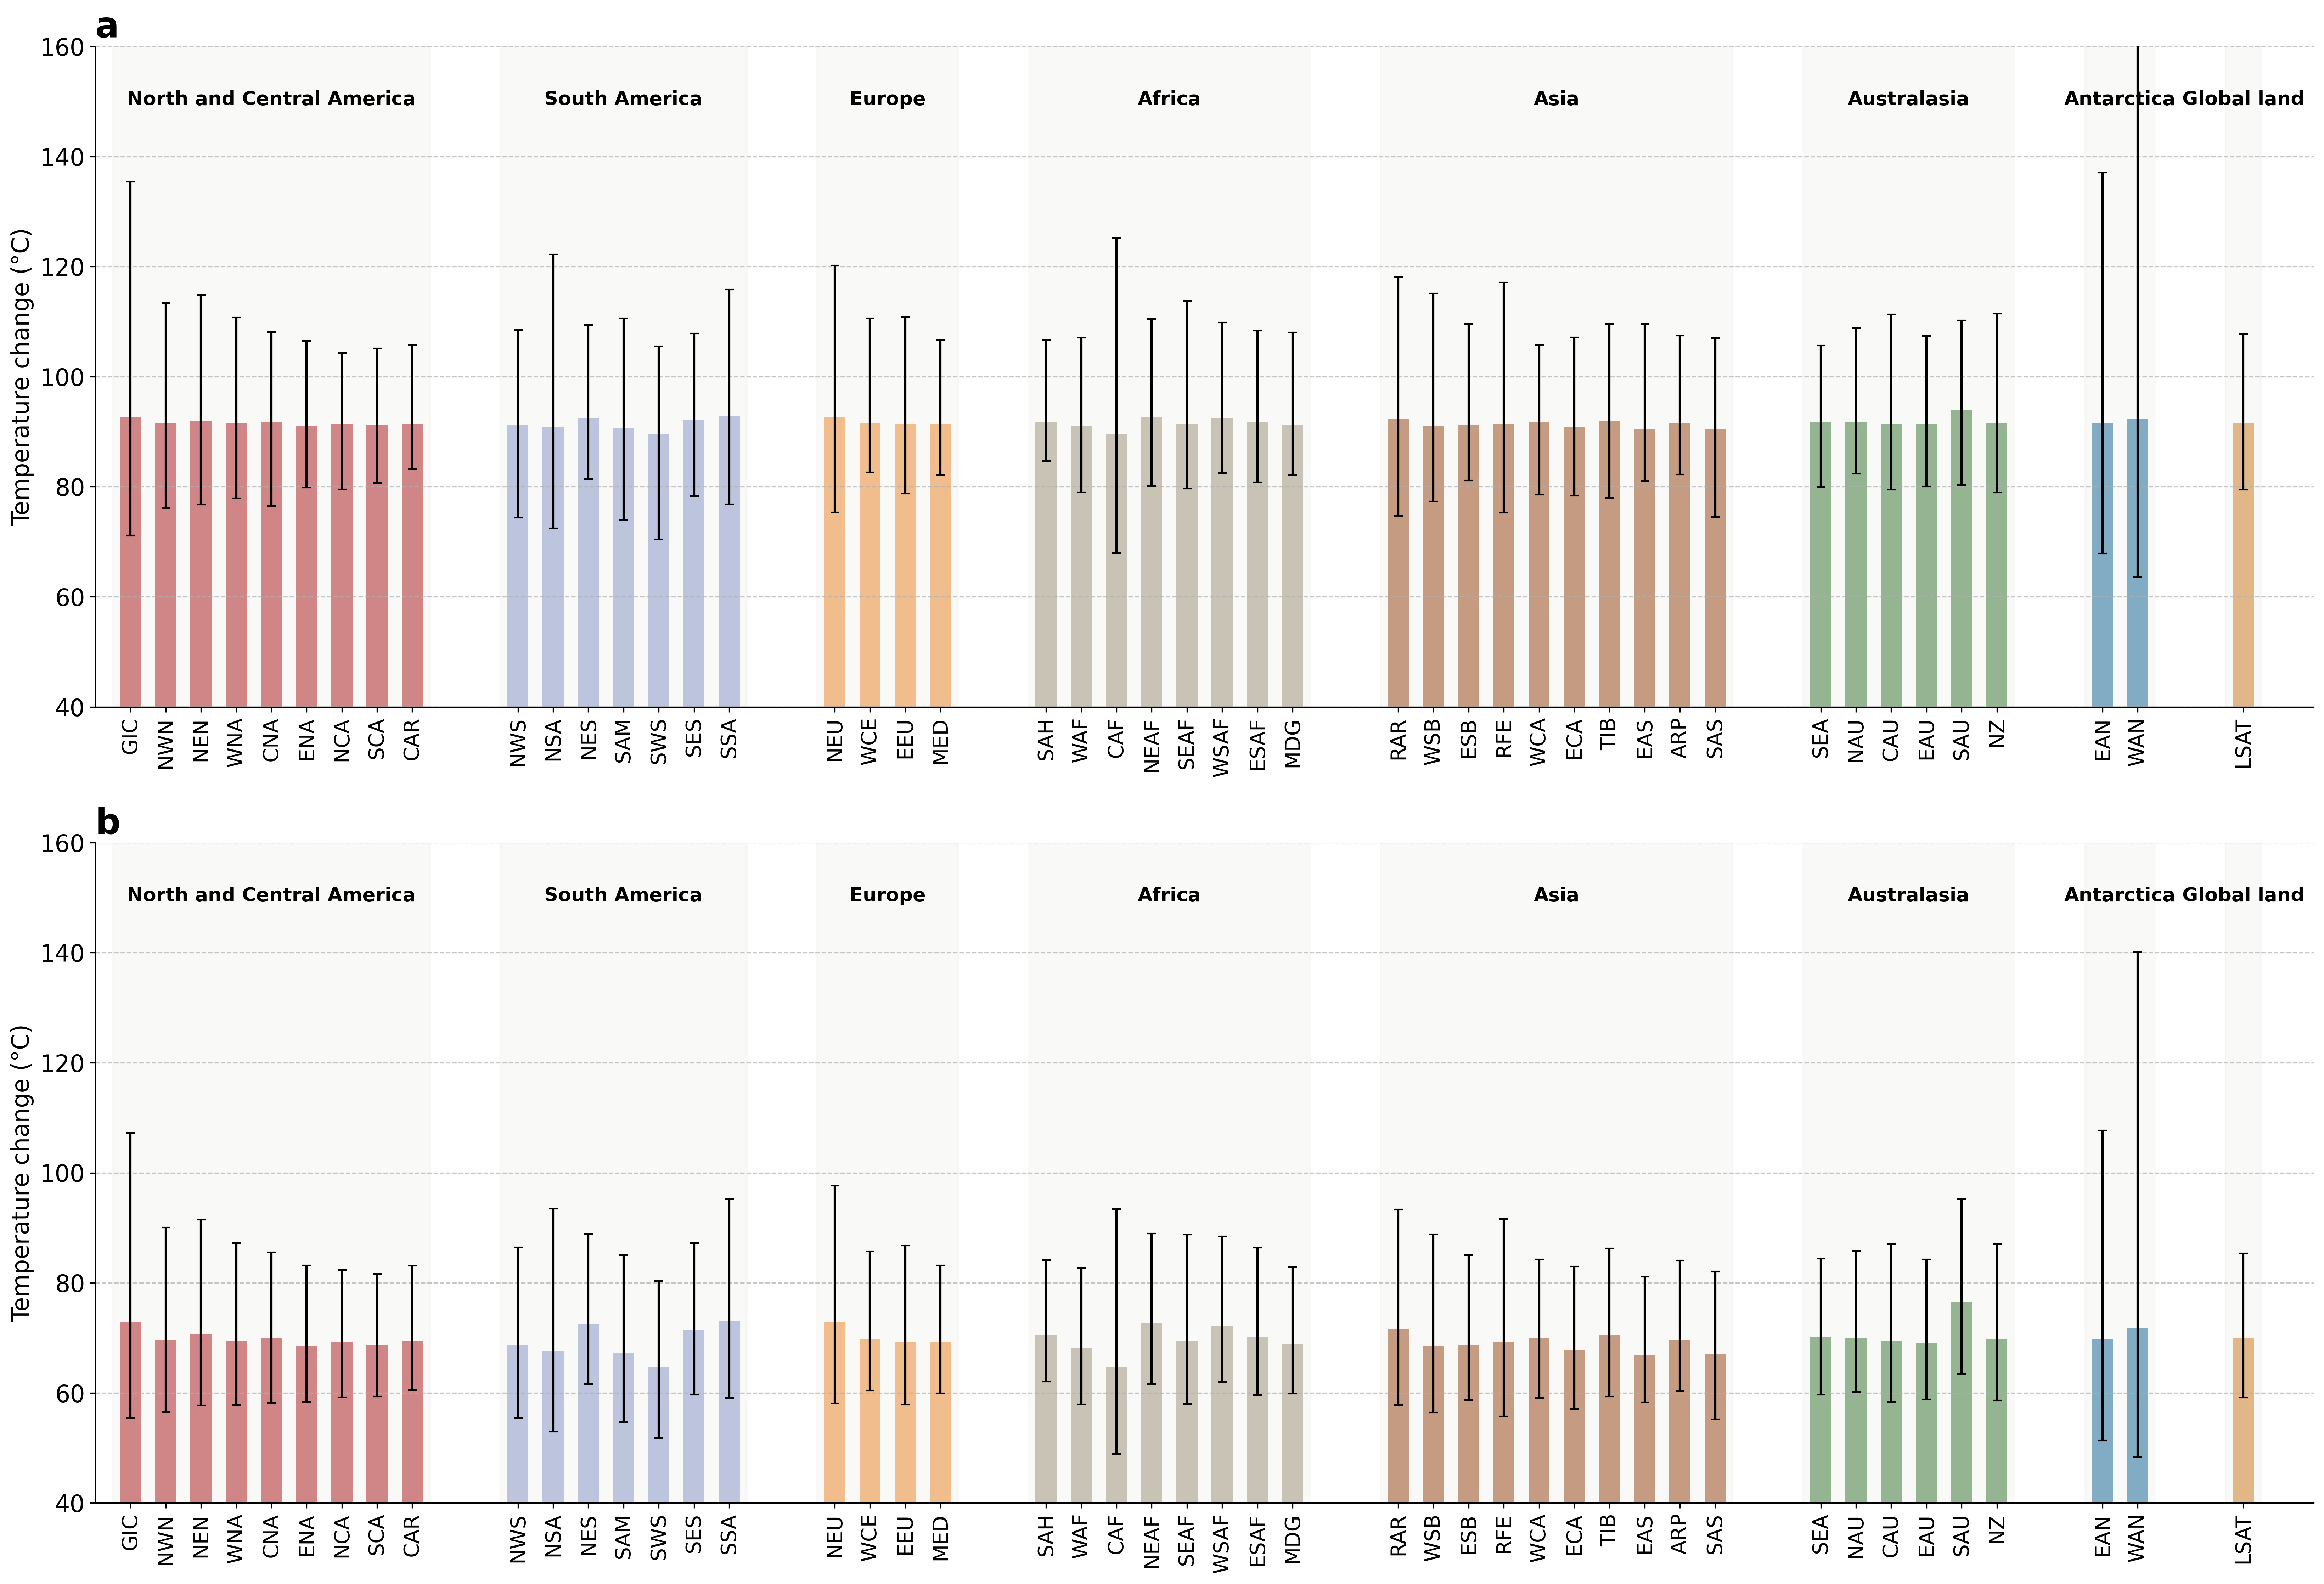

In [16]:

# Create the figure with two rows instead of one
fig, axs = plt.subplots(2, 1, figsize=(22, 15), dpi=300, sharey=True)

# Top panel
plot_panel(
    axs[0],
    percent_nowaday_15,
    # '(a) Nowadays to 1.5°C, Warming Occurred (%)',
    'a',
    colors,
    continent_indices,
    labels,
    'Temperature change (°C)',
    continent_height_value=152,  # lift up labels for tighter spacing
    ylim_low=40,
    ylim_high=160
)

# Bottom panel
plot_panel(
    axs[1],
    percent_nowaday_2,
    # '(b) Nowadays to 2°C, Warming Occurred (%)',
    'b',
    colors,
    continent_indices,
    labels,
    'Temperature change (°C)',
    continent_height_value=152,
    ylim_low=40,
    ylim_high=160
)

plt.tight_layout(h_pad=2.0)  # reduce vertical spacing between subplots
# main_title = f"(a) Attributable warming to ALL-forcing"
# fig.suptitle(main_title, fontsize=20, fontweight='bold', x = 0.63, y=1.02, ha = 'right')

plt.show()

### AR6 region, area-mean-average

In [17]:
percent_reg_15 = percent_nowaday_15.sel(quantile = 'mean')
percent_reg_2 = percent_nowaday_2.sel(quantile = 'mean')
warming_reg_15 = (post_warming_15_ref2025.sel(quantile = 'mean') + post_warming_current_year)
warming_reg_2 = (post_warming_2_ref2025.sel(quantile = 'mean') + post_warming_current_year)


In [18]:
percent_reg_15_weighted_glob = compute_global_area_average(percent_reg_15)
percent_reg_2_weighted_glob = compute_global_area_average(percent_reg_2)

warming_reg_15_weighted_glob = compute_global_area_average(warming_reg_15)
warming_reg_2_weighted_glob = compute_global_area_average(warming_reg_2)

In [19]:
percent_15_constraint_glob = percent_nowaday_15.isel(region = slice(46, 47)).sel(quantile = 'mean')
percent_2_constraint_glob = percent_nowaday_2.isel(region = slice(46, 47)).sel(quantile = 'mean')

warming_15_constraint_glob = (post_warming_15_ref2025.sel(quantile = 'mean') + post_warming_current_year).isel(region = slice(46, 47))
warming_2_constraint_glob = (post_warming_2_ref2025.sel(quantile = 'mean') + post_warming_current_year).isel(region = slice(46, 47))


In [20]:
print(warming_15_constraint_glob)
print(warming_reg_15_weighted_glob)

print(warming_2_constraint_glob)
print(warming_reg_2_weighted_glob)


<xarray.DataArray 'post_mean_5_95_smooth' (region: 1)> Size: 8B
array([2.02860031])
Coordinates:
  * region       (region) int64 8B 46
    forcing      <U3 12B 'ALL'
    quantile     <U4 16B 'mean'
    abbrevs      (region) <U4 16B 'LSAT'
    names        (region) <U25 100B 'Global Land'
    realization  int64 8B 100
    year         int64 8B 2025
<xarray.DataArray ()> Size: 8B
array(2.09618443)
Coordinates:
    forcing      <U3 12B 'ALL'
    quantile     <U4 16B 'mean'
    realization  int64 8B 100
    year         int64 8B 2025
<xarray.DataArray 'post_mean_5_95_smooth' (region: 1)> Size: 8B
array([2.65910228])
Coordinates:
  * region       (region) int64 8B 46
    forcing      <U3 12B 'ALL'
    quantile     <U4 16B 'mean'
    abbrevs      (region) <U4 16B 'LSAT'
    names        (region) <U25 100B 'Global Land'
    realization  int64 8B 100
    year         int64 8B 2025
<xarray.DataArray ()> Size: 8B
array(2.74890757)
Coordinates:
    forcing      <U3 12B 'ALL'
    quantile     <U4 

In [21]:
print(percent_15_constraint_glob)
print(percent_reg_15_weighted_glob)

print(percent_2_constraint_glob)
print(percent_reg_2_weighted_glob)


<xarray.DataArray 'post_mean_5_95_smooth' (region: 1)> Size: 8B
array([91.6321289])
Coordinates:
  * region       (region) int64 8B 46
    year         int64 8B 2025
    forcing      <U3 12B 'ALL'
    abbrevs      (region) <U4 16B 'LSAT'
    names        (region) <U25 100B 'Global Land'
    realization  int64 8B 100
    quantile     <U4 16B 'mean'
<xarray.DataArray ()> Size: 8B
array(91.58336465)
Coordinates:
    year         int64 8B 2025
    forcing      <U3 12B 'ALL'
    realization  int64 8B 100
    quantile     <U4 16B 'mean'
<xarray.DataArray 'post_mean_5_95_smooth' (region: 1)> Size: 8B
array([69.90515817])
Coordinates:
  * region       (region) int64 8B 46
    year         int64 8B 2025
    forcing      <U3 12B 'ALL'
    abbrevs      (region) <U4 16B 'LSAT'
    names        (region) <U25 100B 'Global Land'
    realization  int64 8B 100
    quantile     <U4 16B 'mean'
<xarray.DataArray ()> Size: 8B
array(69.81341772)
Coordinates:
    year         int64 8B 2025
    forcing      <

In [22]:
file_name = '2.0.real_obs_constrain_prior_post_warming_2016-2025_ref.1850-1900.nc'
post_warm = xr.open_dataarray(path + file_name).sel(scheme = 'post', quantile = 'mean')

global_constrained_warm = post_warm.sel(region = 46)
global_weighted_warm = compute_global_area_average(post_warm)


forcings = global_constrained_warm.forcing.values  # or da1.region.values
x = np.arange(len(forcings))
width = 0.35  # bar width




In [87]:
def plot_grouped_bars(ax, labels, data_dict, ylabel, ylim=None, xlim=None,
                      legend_loc="upper right", title=None, legend=True):

    # Two x positions: one for 1.5°C, one for 2°C
    x = np.array([0, 1])
    width = 0.30

    # Colors
    c15 = '#bc4749'
    c2  = '#4f772d'

    # Group keys by temperature target
    keys_15 = [k for k in data_dict if "1.5°C" in k]
    keys_2  = [k for k in data_dict if "2°C"  in k]
    print(keys_2)

    # Offsets for showing 2 bars in each group
    offsets = [-0.15, 0.15]   # adjust as needed

    # Plot 1.5°C bars at x=0
    for k, off in zip(keys_15, offsets):
        ax.bar(0 + off, data_dict[k], width,
               color=c15, alpha=0.7 if "Weighted" in k else 0.4,
               label=k)

    # Plot 2°C bars at x=1
    for k, off in zip(keys_2, offsets):
        ax.bar(1 + off, data_dict[k], width,
               color=c2, alpha=0.7 if "Weighted" in k else 0.4,
               label=k)

    # X-axis labels
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["1.5°C", "2°C"], fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', alpha=0.3)


    ax.set_ylabel(ylabel)
    if ylim: ax.set_ylim(ylim)
    if xlim: ax.set_xlim(xlim)
    if legend:
        ax.legend(loc=legend_loc)

    if title:
        ax.set_title(title, weight='bold', loc='left', fontsize=14, pad=6)


# ============================================================
# MASTER FUNCTION — (1 top) + (2 bottom)
# ============================================================
def plot_global_plus_two_panels(global_constrained, global_weighted, forcings,
                                percent_data, warming_data):

    # Create layout: 2 rows, 2 columns
    fig = plt.figure(figsize=(12, 12), dpi=300)

    # GridSpec: row heights (top tall, bottom shorter)
    gs = fig.add_gridspec(2, 2, height_ratios=[1.2, 1])

    # ---------------------------------------------------------
    # PANEL A (top, spanning 2 columns)
    # ---------------------------------------------------------
    axA = fig.add_subplot(gs[0, :])

    x = np.arange(len(forcings))
    width = 0.35

    axA.bar(x - width/2, global_weighted, width,
            label='Weighted 2016-2025',
            color='#457b9d', alpha=0.7)

    axA.bar(x + width/2, global_constrained, width,
            label='Constrained 2016-2025',
            color='#457b9d', alpha=0.4)

    axA.set_xticks(x)
    axA.set_xticklabels(forcings, rotation=0, ha='right', fontsize=12)
    axA.set_ylabel("Global land warming (°C)", fontsize=13)
    axA.grid(axis='y', alpha=0.3)
    axA.legend(loc="upper right", fontsize=10)
    axA.set_ylim(-0.6, 4.0)
    axA.spines['top'].set_visible(False)
    axA.spines['right'].set_visible(False)
    axA.set_title("a", weight="bold", fontsize=15, loc='left')

    # ---------------------------------------------------------
    # PANEL B — bottom left
    # ---------------------------------------------------------
    labels = ['Global land']

    axB = fig.add_subplot(gs[1, 0])
    plot_grouped_bars(
        axB, labels, percent_data,
        ylabel="Percent occurred (%)",
        ylim=(40, 100),
        xlim=(-1, 2),
        legend_loc="upper right",
        title="b"
    )

    # ---------------------------------------------------------
    # PANEL C — bottom right
    # ---------------------------------------------------------
    axC = fig.add_subplot(gs[1, 1])
    plot_grouped_bars(
        axC, labels, warming_data,
        ylabel="Attributable warming (°C)",
        ylim=(0, 4),
        xlim=(-1, 2),
        legend_loc="upper right",
        title="c"
    )

    plt.tight_layout()

    plt.subplots_adjust(
    wspace=0.3,   # width space between columns
    hspace=0.2,   # height space between rows
    left=0.08,
    right=0.95,
    top=0.95,
    bottom=0.08)

    plt.show()

['Weighted 2°C', 'Constraint 2°C']
['Weighted 2°C', 'Constraint 2°C']


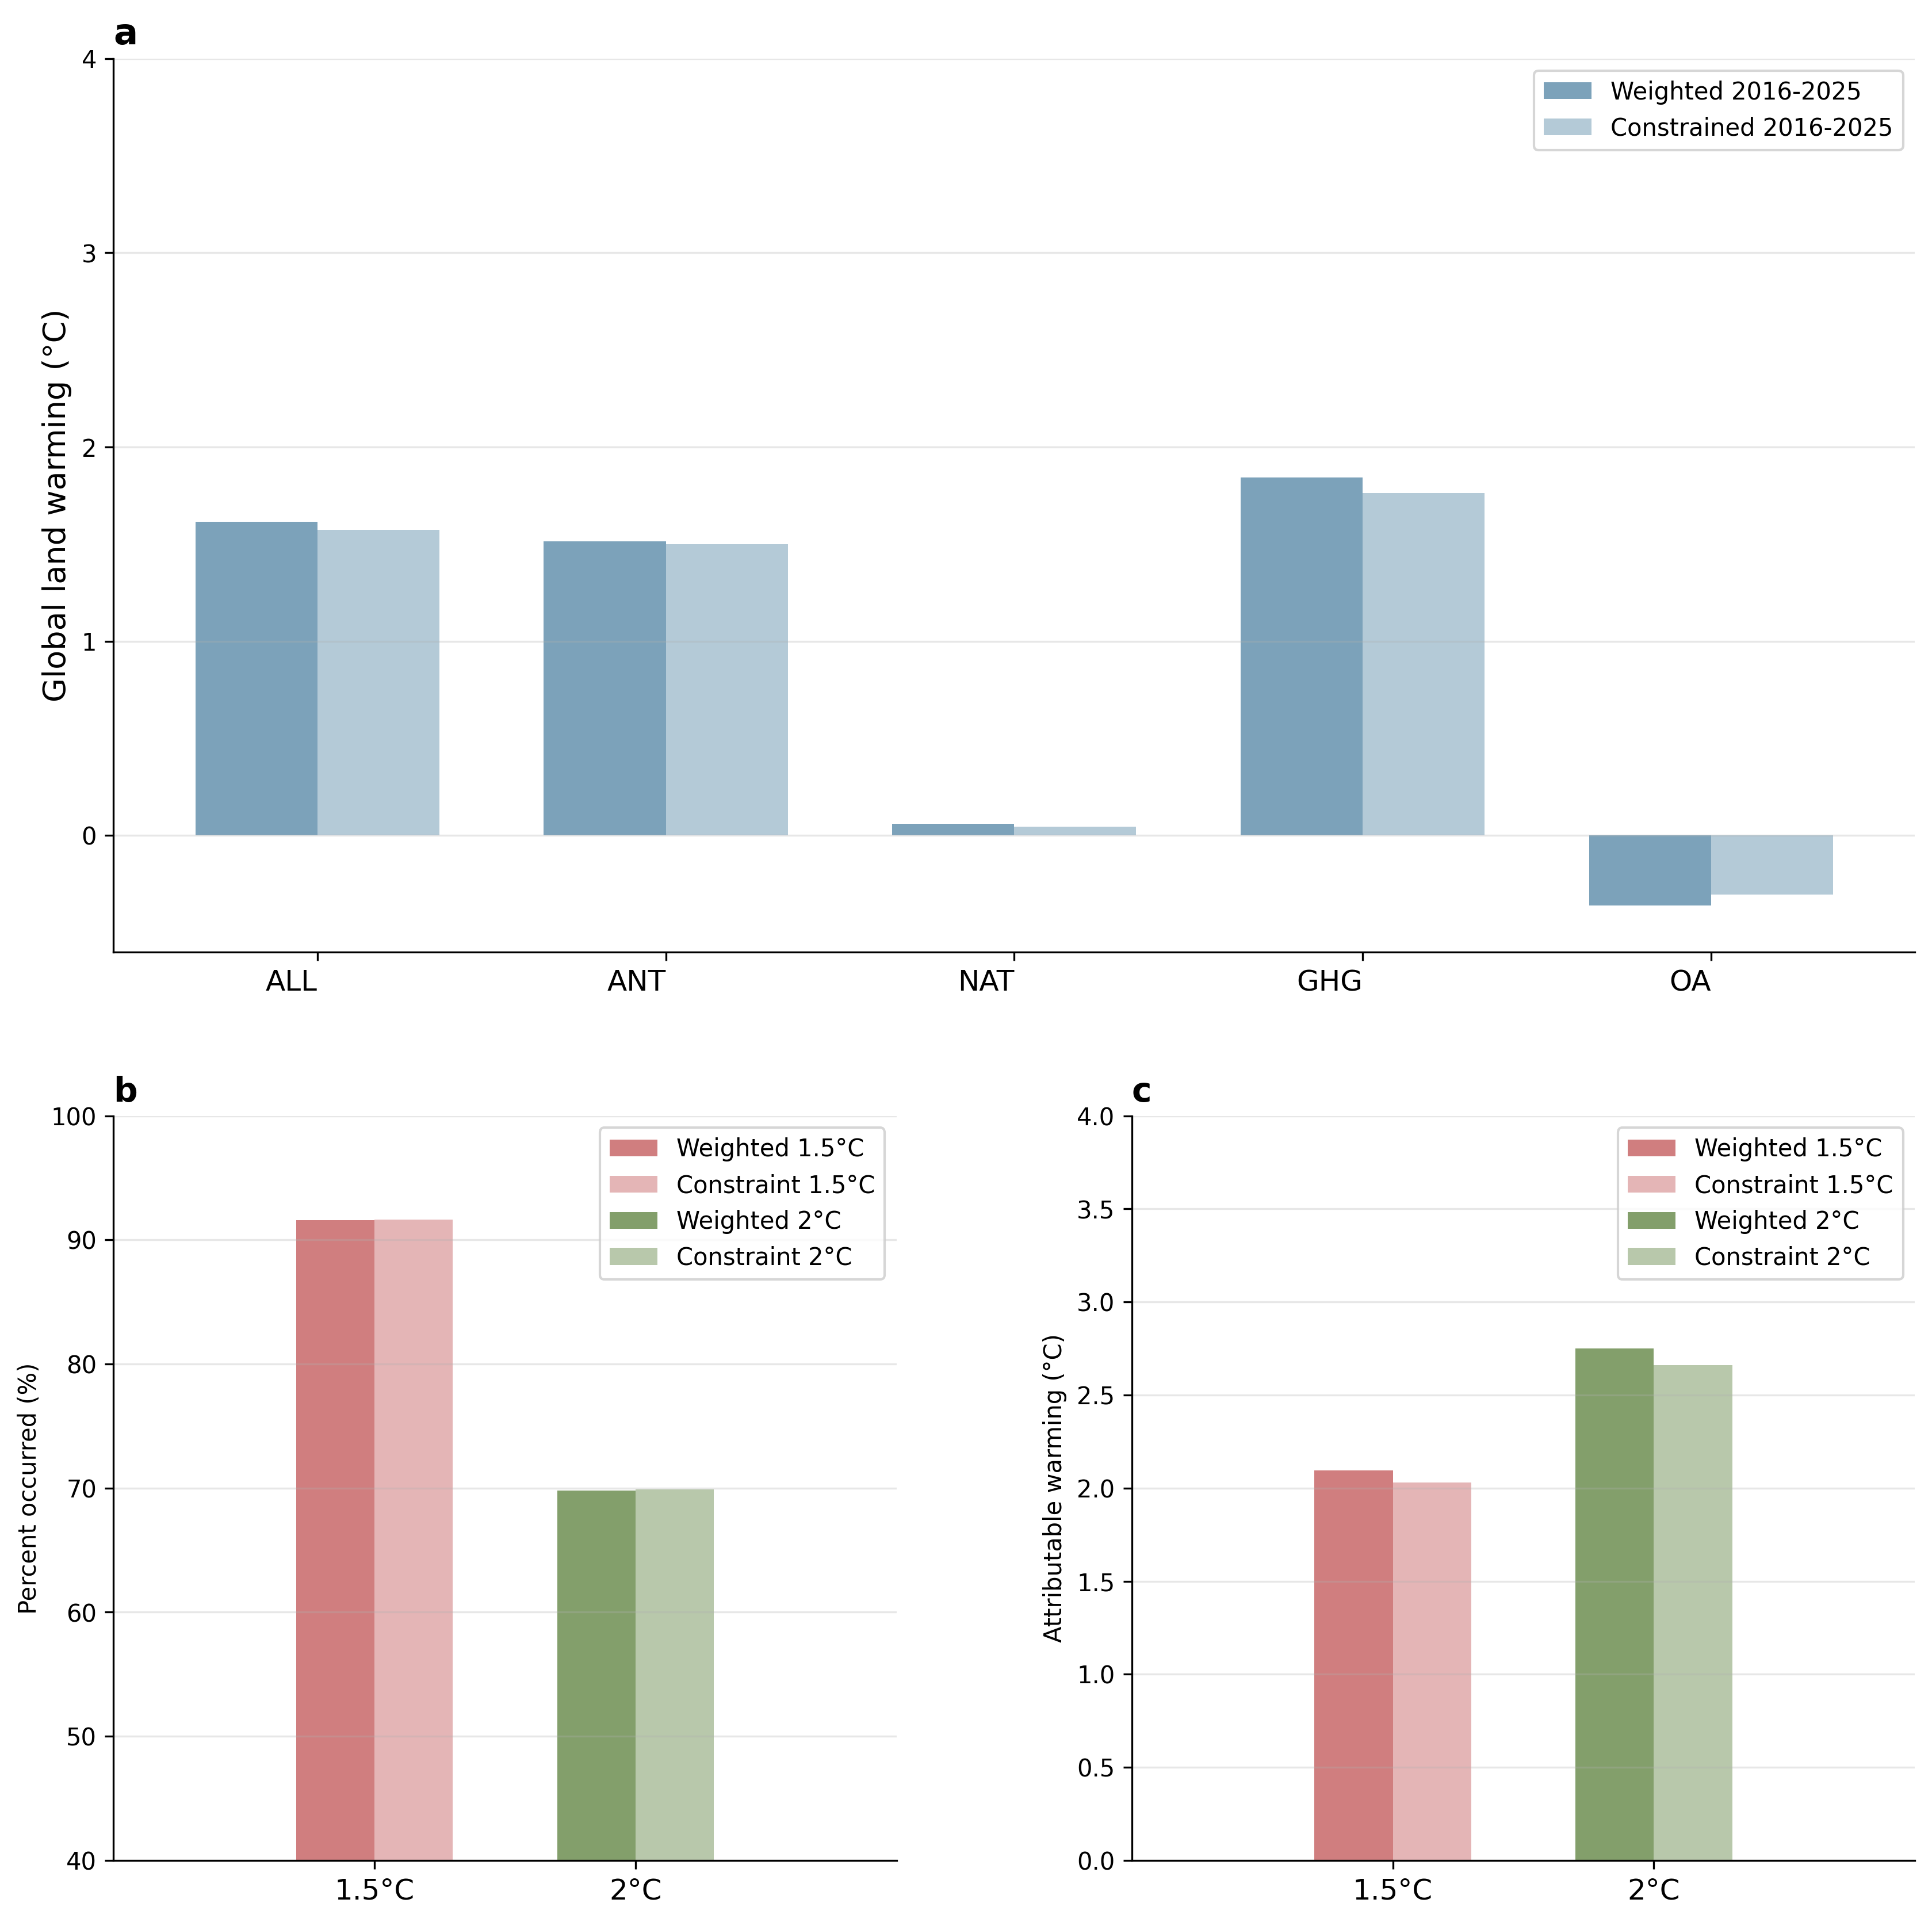

In [88]:
percent_data = {
    "Weighted 1.5°C": percent_reg_15_weighted_glob.values,
    "Constraint 1.5°C": percent_15_constraint_glob.values,
    "Weighted 2°C": percent_reg_2_weighted_glob.values,
    "Constraint 2°C": percent_2_constraint_glob.values,
}

warming_data = {
    "Weighted 1.5°C": warming_reg_15_weighted_glob.values,
    "Constraint 1.5°C": warming_15_constraint_glob.values,
    "Weighted 2°C": warming_reg_2_weighted_glob.values,
    "Constraint 2°C": warming_2_constraint_glob.values,
}

plot_global_plus_two_panels(
    global_constrained_warm,
    global_weighted_warm,
    forcings,
    percent_data,
    warming_data
)